---
title: "Data Analytics for Banking Coursework"
author:
  - name: Pietro Rota
    affiliation:
      - name: Bayes Business School – City, St George’s University of London
        city: London
        state: UK
        url: https://www.bayes.citystgeorges.ac.uk/
jupyter: python3

format:
  html:
    toc: true
    code-tools: true
    code-fold: true
    code-summary: "Show code"
    fig-dpi: 500
    fig.path: "figures/"
    self-contained: true
    fig.format: "png"
    df-print: kable
    code-block-border-left: royalblue
    code-block-bg: true
    font-family: system-ui
    html-table-processing: none
    # mathjax: "https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"
    html-math-method: katex

execute:
  echo: true
  output: true
  warning: false
  message: false
---

**TO RENDER CORRECTLY**: 

quarto preview "c:/Users/pietr/OneDrive - City St George's, University of London/Documents/a2025-2026 BAYES/DABF - Data Analytics for Banking & Finance/DABF_code/Groupwork/Groupwork.ipynb" --to html --no-watch-inputs --execute

In [5]:
#| label: setup
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.api import OLS, add_constant
from great_tables import GT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Current Time:", datetime.now())


Current Time: 2025-11-27 13:19:15.903080


# PRICES

In [6]:
#| label: import_prices
from pathlib import Path
PATH = Path("C:/Users/pietr/OneDrive - City St George's, University of London/Documents/a2025-2026 BAYES/DABF - Data Analytics for Banking & Finance/DABF_code/Groupwork/Data-Analytics-For-Banking/DF.xlsx")

df = pd.read_excel(PATH, sheet_name="PRICES GBP")
# df['Date'] = pd.to_datetime(df['Date'], unit='D')
df.set_index('Date', inplace=True)
df = df.astype(float)

# Inspect the data
df = df.dropna()
df.round(4)


CVX US Equity  FSLR US Equity  ENI IM Equity  XOM US Equity  \
Date                                                                      
2024-11-01        22.6098        158.5241        11.7630        88.9155   
2024-11-04        22.9469        163.8469        11.7849        91.5483   
2024-11-05        22.9860        165.6360        11.8373        91.2690   
2024-11-06        23.3980        150.5198        11.6541        93.8712   
2024-11-07        23.3179        151.4242        11.7200        93.2640   
...                   ...             ...            ...            ...   
2025-10-27        26.0762        185.7582        13.9143        86.9507   
2025-10-28        25.9547        180.4625        13.9548        86.6385   
2025-10-29        26.6142        182.7537        14.0564        88.0463   
2025-10-30        26.4350        177.5869        13.9991        87.1968   
2025-10-31        26.7514        203.2744        13.9917        87.0850   

            SHEL LN Equity  VWS DC Equity  EQNR NO Equity  TTE FP Equity  \
Date                                                                       
2024-11-01          25.790        14.9066         18.1238        48.5307   
2024-11-04          25.940        15.3201         18.2802        48.8139   
2024-11-05          26.085        13.4186         18.2319        48.8806   
2024-11-06          25.925        11.6121         17.4024        47.9095   
2024-11-07          25.995        11.9894         17.7310        48.0278   
...                    ...            ...             ...            ...   
2025-10-27          28.320        14.3080         18.3293        46.9308   
2025-10-28          28.330        15.4433         18.2800        46.9788   
2025-10-29          28.755        15.6010         18.3470        47.6764   
2025-10-30          28.830        15.8986         18.3604        47.1680   
2025-10-31          28.475        15.5069         18.1955        47.3439   

            AMRC US Equity  NEE US Equity  SPX Index  
Date                                                  
2024-11-01         25.0077        59.8314  4431.3119  
2024-11-04         25.8413        60.4893  4409.3007  
2024-11-05         27.1597        60.3422  4436.6733  
2024-11-06         24.9418        57.8123  4599.7207  
2024-11-07         24.3572        57.4442  4598.2294  
...                    ...            ...        ...  
2025-10-27         31.1609        64.5193  5156.1122  
2025-10-28         30.7298        62.9434  5190.0957  
2025-10-29         29.9032        61.8176  5209.8821  
2025-10-30         29.6282        62.0695  5186.9079  
2025-10-31         30.0944        61.9860  5208.8029  

[237 rows x 11 columns]

In [7]:
#| label: returns
returns = (df / df.shift(1)-1)
returns = returns.dropna()

SPXreturns = returns["SPX Index"]

full_returns = returns
returns = returns.iloc[:, :-1] # Exclude SPX for initial analysis


In [8]:
#| label: IQR
low = 25
high = 100 - low
q1 = df.quantile(low/100)
q3 = df.quantile(high/100)
iqr = q3 - q1

iqr_df = pd.DataFrame({"Q1": q1, "Q3": q3, "IQR": iqr}).round(4)
iqr_df_sorted = iqr_df.sort_values("IQR", ascending=False)

print("Per-asset IQR (sorted):")
display(iqr_df_sorted)

# Overall IQR across all prices (flattened, excluding NaNs)
all_vals = df.values.flatten()
all_vals = all_vals[~np.isnan(all_vals)]
overall_q1 = np.percentile(all_vals, low)
overall_q3 = np.percentile(all_vals, high)
overall_iqr = overall_q3 - overall_q1

print(f"\nOverall IQR across all prices: {overall_iqr:.4f} (Q1={overall_q1:.4f}, Q3={overall_q3:.4f})")


Per-asset IQR (sorted):


Q1         Q3       IQR
SPX Index       4444.4576  4836.6710  392.2134
FSLR US Equity   116.5226   152.7960   36.2734
AMRC US Equity    10.9921    20.8902    9.8980
XOM US Equity     81.5151    87.7933    6.2781
NEE US Equity     53.3131    57.6399    4.3268
CVX US Equity     22.8686    25.6156    2.7470
VWS DC Equity     10.9956    13.6861    2.6905
TTE FP Equity     44.7375    47.3439    2.6064
ENI IM Equity     11.2447    12.8114    1.5667
SHEL LN Equity    25.3300    26.8300    1.5000
EQNR NO Equity    17.9329    19.2170    1.2841


Overall IQR across all prices: 63.7668 (Q1=17.7403, Q3=81.5071)


In [9]:
#| label: abs_change
last_prices = df.iloc[-1]
first_prices = df.iloc[0]
pd.DataFrame({ "first_prices":first_prices, "last_prices":last_prices,"Change":(last_prices-first_prices)})


first_prices  last_prices      Change
CVX US Equity      22.609839    26.751447    4.141608
FSLR US Equity    158.524134   203.274444   44.750310
ENI IM Equity      11.763028    13.991673    2.228646
XOM US Equity      88.915532    87.084983   -1.830549
SHEL LN Equity     25.790000    28.475000    2.685000
VWS DC Equity      14.906621    15.506851    0.600230
EQNR NO Equity     18.123787    18.195546    0.071758
TTE FP Equity      48.530662    47.343878   -1.186785
AMRC US Equity     25.007735    30.094426    5.086691
NEE US Equity      59.831374    61.985988    2.154615
SPX Index        4431.311881  5208.802924  777.491043

In [10]:
#| label: total_return
returns.sum().sort_values(ascending=False)


AMRC US Equity    0.634550
FSLR US Equity    0.445022
CVX US Equity     0.210595
VWS DC Equity     0.194381
ENI IM Equity     0.193326
SHEL LN Equity    0.119714
NEE US Equity     0.073968
EQNR NO Equity    0.053911
XOM US Equity     0.010326
TTE FP Equity    -0.003804
dtype: float64

days with the highest returns

In [11]:
#| label: Largest Daily Move
DAYS = pd.DataFrame({"Name":returns.columns, "Negative":returns.idxmin(axis=0), "Positive":returns.idxmax(axis=0), 
#"Difference": returns.idxmax(axis=0)-returns.idxmin(axis=0)
})

(
    GT(DAYS)
    .tab_header(title="Date of Largest Daily Move")
    .opt_stylize(5, color = "gray")
)


GT(_tbl_data=                          Name   Negative   Positive
CVX US Equity    CVX US Equity 2025-04-03 2025-04-09
FSLR US Equity  FSLR US Equity 2025-06-17 2025-08-18
ENI IM Equity    ENI IM Equity 2025-04-07 2025-10-23
XOM US Equity    XOM US Equity 2025-04-10 2025-04-09
SHEL LN Equity  SHEL LN Equity 2025-04-04 2025-06-10
VWS DC Equity    VWS DC Equity 2024-11-06 2025-08-18
EQNR NO Equity  EQNR NO Equity 2025-06-24 2025-01-02
TTE FP Equity    TTE FP Equity 2025-04-04 2025-10-15
AMRC US Equity  AMRC US Equity 2025-02-28 2025-08-05
NEE US Equity    NEE US Equity 2025-07-23 2025-04-09, _body=<great_tables._gt_data.Body object at 0x000001C6C2DC6510>, _boxhead=Boxhead([ColInfo(var='Name', type=<ColInfoTypeEnum.default: 1>, column_label='Name', column_align='left', column_width=None), ColInfo(var='Negative', type=<ColInfoTypeEnum.default: 1>, column_label='Negative', column_align='right', column_width=None), ColInfo(var='Positive', type=<ColInfoTypeEnum.default: 1>, column_label='Positive', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001C6C2DC6120>, _spanners=Spanners([]), _heading=Heading(title='Date of Largest Daily Move', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001C6C2DC6900>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#D5D5D5'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D5D5D5'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#D5D5D5'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value

## Descriptive statistics table

In [12]:
#| label: desc_stats
# | column: screen
from scipy.stats import norm
 
desc_stats = pd.DataFrame({
    "Count": returns.count(),
    "Mean": returns.mean(),
    "Std": returns.std(),
    "CV": returns.std()/returns.mean(),
    "Skewness": returns.skew(),
    "Kurtosis": returns.kurt()
})


index_returns = np.array(SPXreturns)
OLS_returns = returns.reset_index()

betas = {}
for ticker in OLS_returns.columns[1:]:
    y = OLS_returns[ticker]
    X = np.array(add_constant(index_returns))
    model = OLS(y, X).fit()
    betas[ticker] = model.params[1]  # beta coefficient
beta_df = pd.DataFrame.from_dict(betas, orient='index', columns=['Beta'])

ADF_test = {}
ADF_pval = {}
for ticker in OLS_returns.columns[1:]:
    model = adfuller(OLS_returns[ticker])
    ADF_test[ticker] = model[0]  # ADF coefficient
    ADF_pval[ticker] = model[1]  # pval 
ADF_test_df = pd.DataFrame.from_dict(ADF_test, orient='index')
ADF_pval_df = pd.DataFrame.from_dict(ADF_pval, orient='index')

JB_test = {}
JB_pval = {}
for ticker in OLS_returns.columns[1:]:
    model = jarque_bera(OLS_returns[ticker])
    JB_test[ticker] = model[0]  # ADF coefficient
    JB_pval[ticker] = model[1]  # pval 
JB_test_df = pd.DataFrame.from_dict(JB_test, orient='index')
JB_pval_df = pd.DataFrame.from_dict(JB_pval, orient='index')


# VAR 5%
VAR5 = {}
VAR1 = {}
for ticker in OLS_returns.columns[1:]:
    VAR5[ticker] = norm.ppf(0.05, loc=desc_stats["Mean"][ticker], scale=desc_stats["Std"][ticker])
    VAR1[ticker] = norm.ppf(0.01, loc=desc_stats["Mean"][ticker], scale=desc_stats["Std"][ticker])
VAR5_df = pd.DataFrame.from_dict(VAR5, orient='index')
VAR1_df = pd.DataFrame.from_dict(VAR1, orient='index')

desc_stats['CV'] = desc_stats["Std"]/desc_stats["Mean"]
desc_stats['Beta'] = beta_df
# desc_stats['ADF test'] = ADF_test_df 
# desc_stats['ADF p-value'] = ADF_pval_df
# desc_stats['JB test'] = JB_test_df
# desc_stats['JB p-value'] = JB_pval_df
desc_stats['VAR 5%'] = VAR5_df
desc_stats['VAR 1%'] = VAR1_df

# desc_stats = desc_stats.round(5)
desc_stats['Name'] = returns.columns
# cols_to_select = desc_stats.columns.drop("Name")
(
    GT(desc_stats).cols_move_to_start(columns="Name")
    .tab_header(title="Descriptive Statistics for selected companies", 
    #    subtitle="S&P 500 used as refernence index"
    )
    .opt_stylize(5, color = "gray")
    .fmt(lambda x: f"{x:.2e}", columns=["Mean", "Std", 
    # "ADF p-value", "JB p-value"
    ])
    .fmt(lambda x: f"{x:.4f}", columns=["Skewness","Kurtosis", "CV", "Beta", 
    # "ADF test"
    ])
    .fmt(lambda x: f"{x:.4%}", columns=['VAR 5%', 'VAR 1%'])
    .fmt_integer(columns = "Count")


    # .fmt(lambda x: f"{x:.2f}", columns=["JB test"])

)


<positron-console-cell-12>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


GT(_tbl_data=                Count      Mean       Std          CV  Skewness   Kurtosis  \
CVX US Equity     236  0.000892  0.018914   21.195842 -0.539554   4.236705   
FSLR US Equity    236  0.001886  0.041376   21.942321  1.095284   7.016190   
ENI IM Equity     236  0.000819  0.012911   15.760884 -1.075915   4.337396   
XOM US Equity     236  0.000044  0.016201  370.261098 -0.816107   2.483279   
SHEL LN Equity    236  0.000507  0.013195   26.012040 -1.089362   4.088753   
VWS DC Equity     236  0.000824  0.036452   44.256672  0.465705   4.139304   
EQNR NO Equity    236  0.000228  0.020553   89.971239 -0.430505   1.974163   
TTE FP Equity     236 -0.000016  0.013319 -826.414950 -0.550360   1.566528   
AMRC US Equity    236  0.002689  0.062550   23.263402  1.375836  19.268184   
NEE US Equity     236  0.000313  0.018102   57.754501 -0.157804   1.568112   

                    Beta    VAR 5%    VAR 1%            Name  
CVX US Equity   0.690042 -0.030219 -0.043108   CVX US Equity  
FSLR US Equity  0.661397 -0.066172 -0.094370  FSLR US Equity  
ENI IM Equity   0.019709 -0.020417 -0.029216   ENI IM Equity  
XOM US Equity   0.639064 -0.026604 -0.037644   XOM US Equity  
SHEL LN Equity  0.102197 -0.021196 -0.030189  SHEL LN Equity  
VWS DC Equity  -0.303693 -0.059134 -0.083976   VWS DC Equity  
EQNR NO Equity -0.046467 -0.033578 -0.047584  EQNR NO Equity  
TTE FP Equity   0.022091 -0.021924 -0.031001   TTE FP Equity  
AMRC US Equity  1.057767 -0.100197 -0.142824  AMRC US Equity  
NEE US Equity   0.296653 -0.029461 -0.041797   NEE US Equity  , _body=<great_tables._gt_data.Body object at 0x000001C6C2DCAFD0>, _boxhead=Boxhead([ColInfo(var='Name', type=<ColInfoTypeEnum.default: 1>, column_label='Name', column_align='left', column_width=None), ColInfo(var='Count', type=<ColInfoTypeEnum.default: 1>, column_label='Count', column_align='right', column_width=None), ColInfo(var='Mean', type=<ColInfoTypeEnum.default: 1>, column_label='Mean', column_align='right', column_width=None), ColInfo(var='Std', type=<ColInfoTypeEnum.default: 1>, column_label='Std', column_align='right', column_width=None), ColInfo(var='CV', type=<ColInfoTypeEnum.default: 1>, column_label='CV', column_align='right', column_width=None), ColInfo(var='Skewness', type=<ColInfoTypeEnum.default: 1>, column_label='Skewness', column_align='right', column_width=None), ColInfo(var='Kurtosis', type=<ColInfoTypeEnum.default: 1>, column_label='Kurtosis', column_align='right', column_width=None), ColInfo(var='Beta', type=<ColInfoTypeEnum.default: 1>, column_label='Beta', column_align='right', column_width=None), ColInfo(var='VAR 5%', type=<ColInfoTypeEnum.default: 1>, column_label='VAR 5%', column_align='right', column_width=None), ColInfo(var='VAR 1%', type=<ColInfoTypeEnum.default: 1>, column_label='VAR 1%', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001C6C3121810>, _spanners=Spanners([]), _heading=Heading(title='Descriptive Statistics for selected companies', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001C6C505DD10>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000001C6C2DC63C0>, <great_tables._gt_data.FormatInfo object at 0x000001C6C505C550>, <great_tables._gt_data.FormatInfo object at 0x000001C6C505D590>, <great_tables._gt_data.FormatInfo object at 0x000001C6C2DCBA80>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=Op

<positron-console-cell-13>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



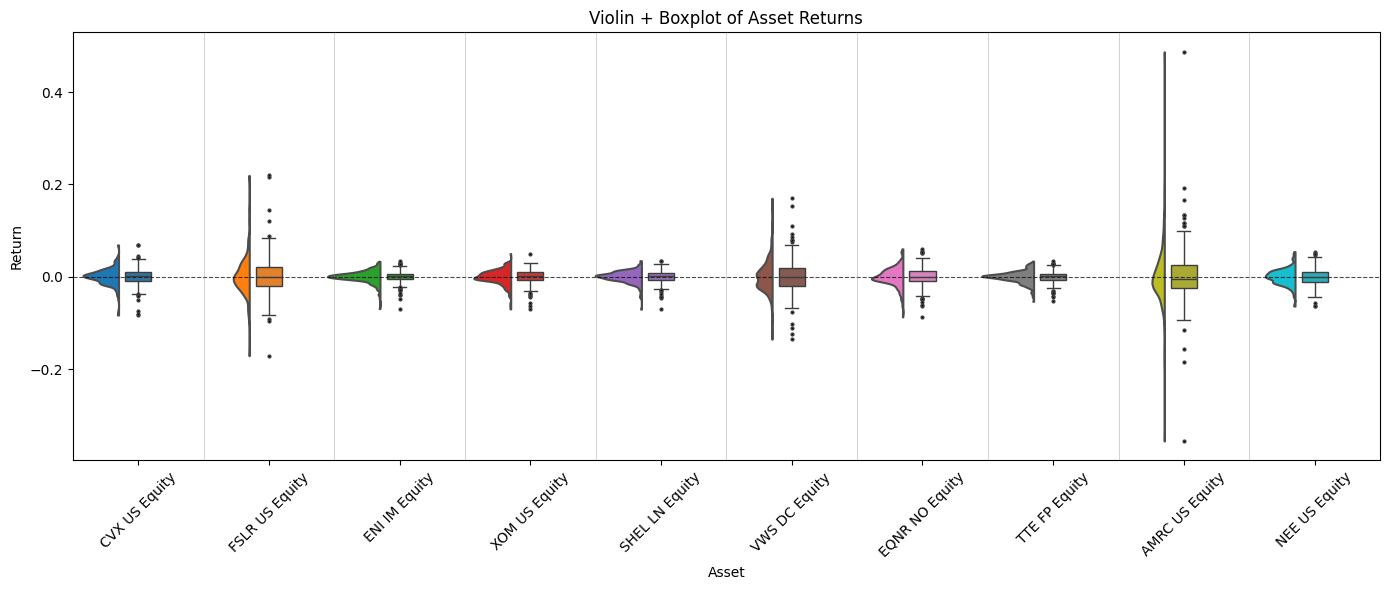

In [13]:
#| label: violin_boxplot_enhanced
import ptitprince as pt
melted = returns.melt(var_name="Asset", value_name="Return")

plt.figure(figsize=(14, 6))


pt.half_violinplot(
    x="Asset",
    y="Return",
    data=melted,
    palette="tab10",
    bw=.2,
    cut=0.,
    scale="area",
    inner=None,
    orient="v"
)
sns.boxplot(
    data=melted,
    x="Asset",
    y="Return",
    width=0.2,
    palette="tab10",
    showcaps=True,
    flierprops = dict(marker='o', markerfacecolor='black', markersize=2, linestyle='none')
    # showfliers=False
)


# 1. Horizontal Line at y=0 (Zero Return)
plt.axhline(
    y=0, 
    color='black', 
    linestyle='--', 
    linewidth=0.8, 
    alpha=0.7,
    label='Zero Return' # Adding a label is good practice
)

# 2. Vertical Lines to separate Assets/Boxplots
for i in range(9): # 10 - 1
    plt.axvline(
        x=i + 0.5, # Place the line exactly between asset i and asset i+1
        color='gray', 
        linestyle='-', 
        linewidth=0.5, 
        alpha=0.5
    )


plt.title("Violin + Boxplot of Asset Returns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


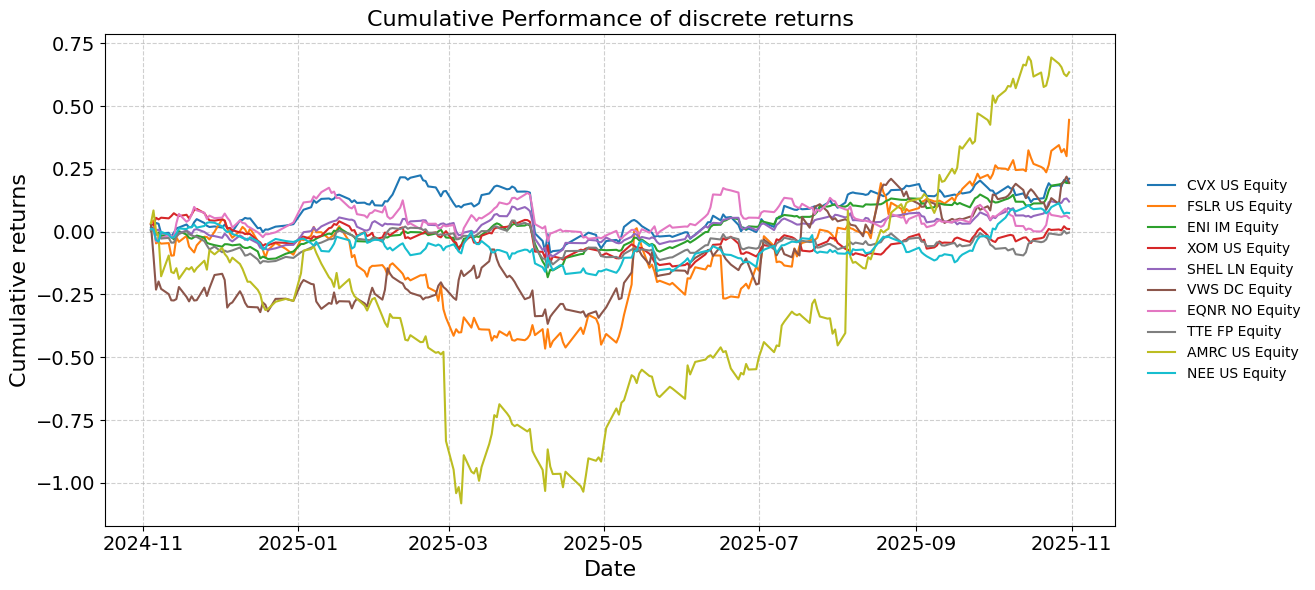

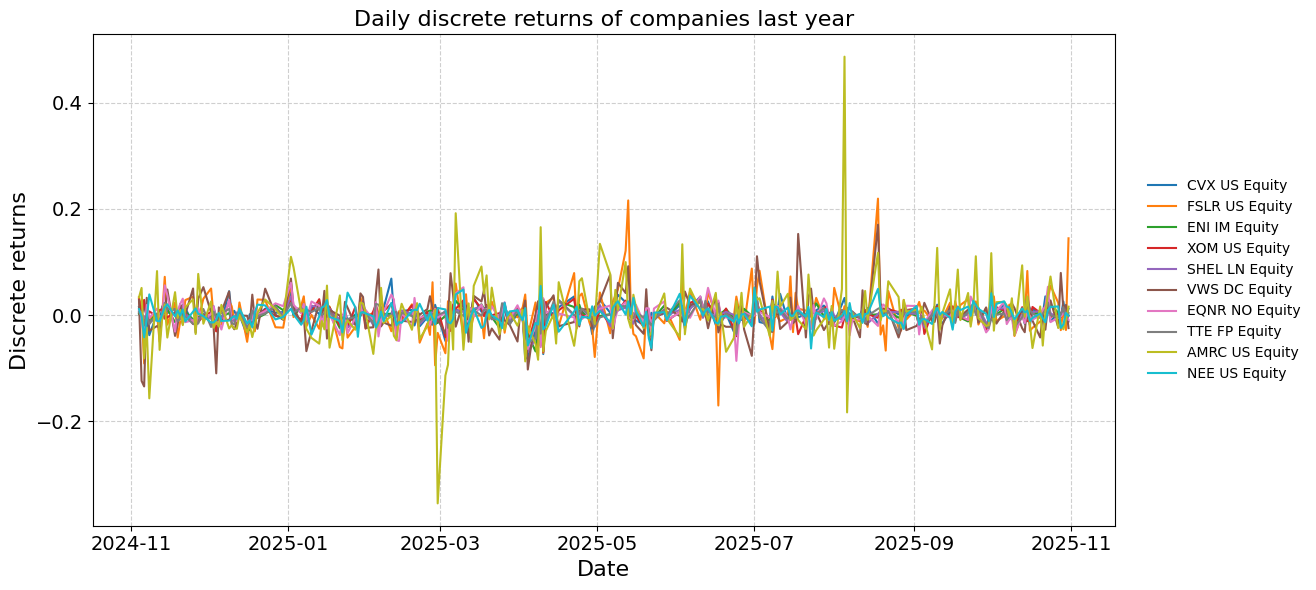

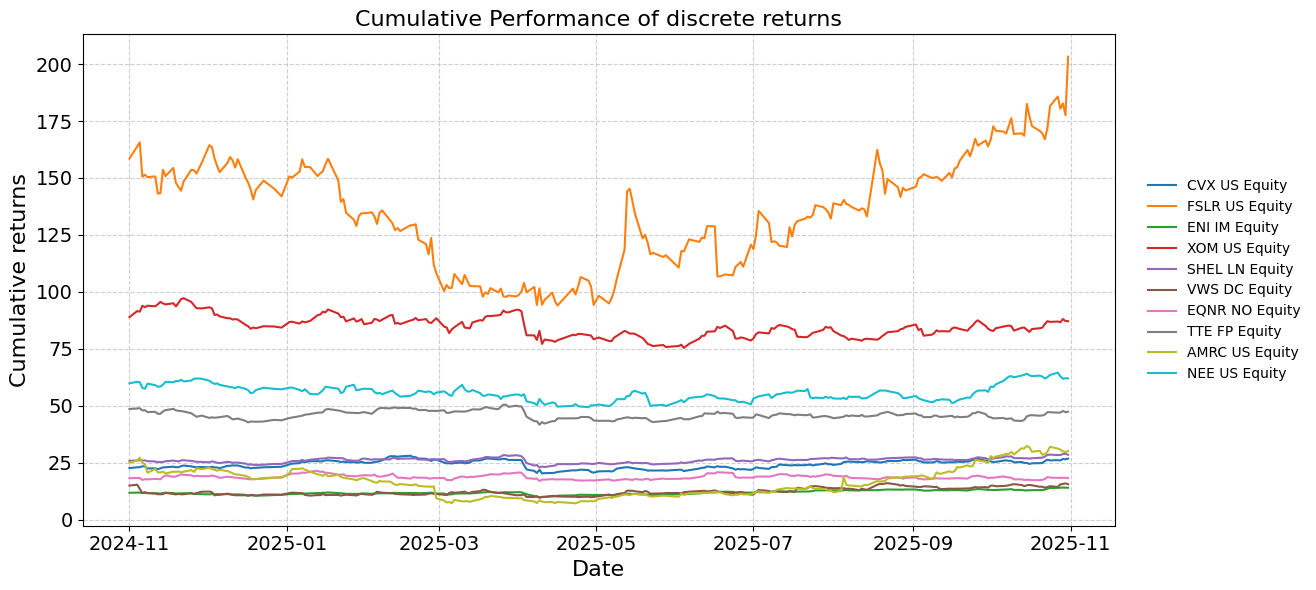

Day with the lowest returns


VWS DC Equity    2024-11-06
AMRC US Equity   2025-02-28
CVX US Equity    2025-04-03
SHEL LN Equity   2025-04-04
TTE FP Equity    2025-04-04
ENI IM Equity    2025-04-07
XOM US Equity    2025-04-10
FSLR US Equity   2025-06-17
EQNR NO Equity   2025-06-24
NEE US Equity    2025-07-23
dtype: datetime64[ns]

In [14]:
#| label: cumulative_performance
avgstd = np.mean(desc_stats["Std"])
df2 = df.drop("SPX Index", axis=1)
plt.figure(figsize=(14, 6))
for company in returns.columns:
    plt.plot((np.cumsum(returns[company])))
plt.legend(labels=returns.columns,loc='center left', bbox_to_anchor=(1.02, 0.5), 
    ncol=1,frameon=False)
plt.title("Cumulative Performance of discrete returns", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Cumulative returns", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)  # shrink labels
plt.yticks(fontsize=14)  # shrink labels

plt.tight_layout()                 # makes space for title/axes
plt.subplots_adjust(right=0.8)     # extra: leaves space for legend
plt.show()


low  = 1
mid  = 2
high = 3

#| label: cumulative_performance
plt.figure(figsize=(14, 6))
for company in returns.columns:
    plt.plot(returns[company])
plt.legend(labels=returns.columns,loc='center left', bbox_to_anchor=(1.02, 0.5), 
    ncol=1,frameon=False)
plt.title("Daily discrete returns of companies last year", fontsize=16)
plt.xlabel("Date", fontsize=16)
# plt.axhline(low*avgstd, color='red', linestyle='--', label='Market Beta = 1')
# plt.axhline(mid*avgstd, color='red', linestyle='--', label='Market Beta = 1')
# plt.axhline(high*avgstd, color='red', linestyle='--', label='Market Beta = 1')
# plt.axhline(-low*avgstd, color='red', linestyle='--', label='Market Beta = 1')
# plt.axhline(-mid*avgstd, color='red', linestyle='--', label='Market Beta = 1')
# plt.axhline(-high*avgstd, color='red', linestyle='--', label='Market Beta = 1')
plt.ylabel("Discrete returns", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)  # shrink labels
plt.yticks(fontsize=14)  # shrink labels

plt.tight_layout()                 # makes space for title/axes
plt.subplots_adjust(right=0.8)     # extra: leaves space for legend
plt.show()


plt.figure(figsize=(14, 6))
for company in df2.columns:
    plt.plot(df2[company])
plt.legend(labels=df2.columns,loc='center left', bbox_to_anchor=(1.02, 0.5), 
    ncol=1,frameon=False)
plt.title("Cumulative Performance of discrete returns", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Cumulative returns", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)  # shrink labels
plt.yticks(fontsize=14)  # shrink labels

plt.tight_layout()                 # makes space for title/axes
plt.subplots_adjust(right=0.8)     # extra: leaves space for legend
plt.show()

print("Day with the lowest returns")
returns.idxmin(axis=0).sort_values()


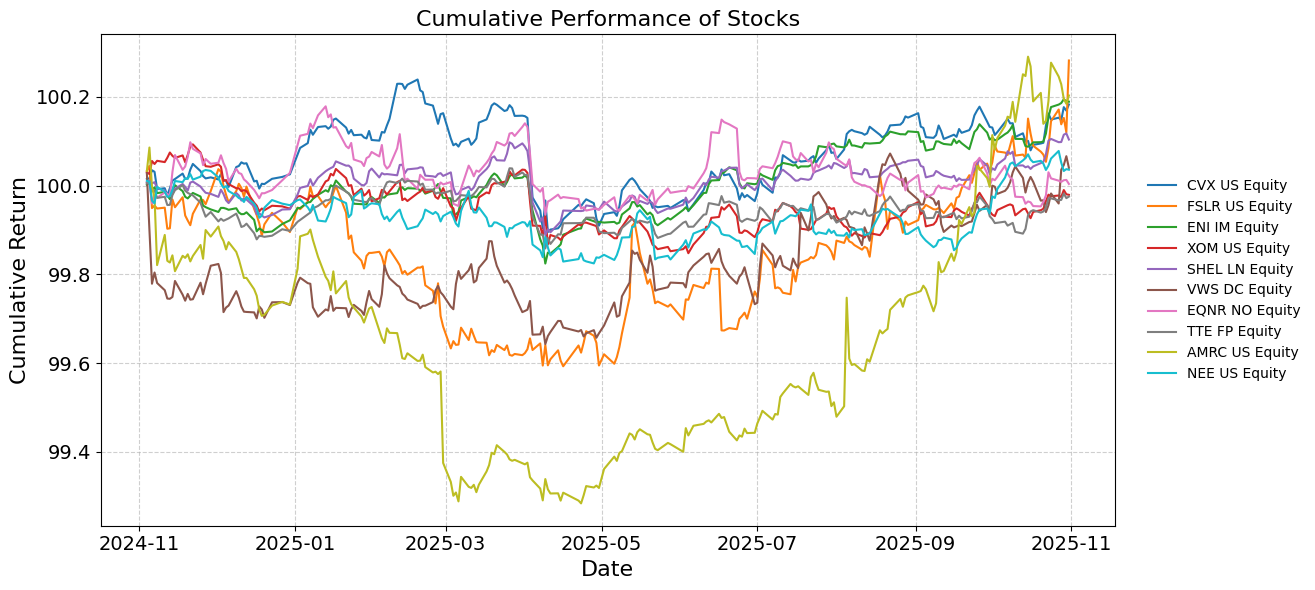

In [15]:
cum_perf = (1 + returns).cumprod() - 1 +100

plt.figure(figsize=(14, 6))

for company in cum_perf.columns:
    plt.plot(cum_perf.index, cum_perf[company], label=company)

plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
           ncol=1, frameon=False)
plt.title("Cumulative Performance of Stocks", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Cumulative Return", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()


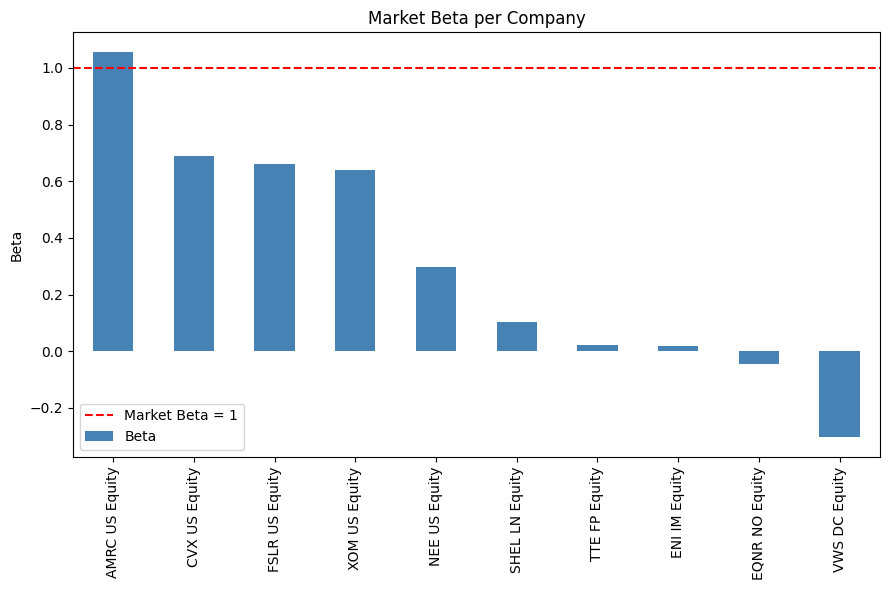

In [16]:
#| label: beta_barplot
sorted_beta = beta_df.sort_values('Beta', ascending=False)
mycolors = ['red' if v < 0 else 'steelblue' for v in sorted_beta['Beta']]
ax = sorted_beta.plot(kind='bar', color=mycolors, legend=False, figsize=(9, 6))
plt.axhline(1, color='red', linestyle='--', label='Market Beta = 1')
plt.title('Market Beta per Company')
plt.ylabel('Beta')
plt.legend()
plt.tight_layout()
plt.show()



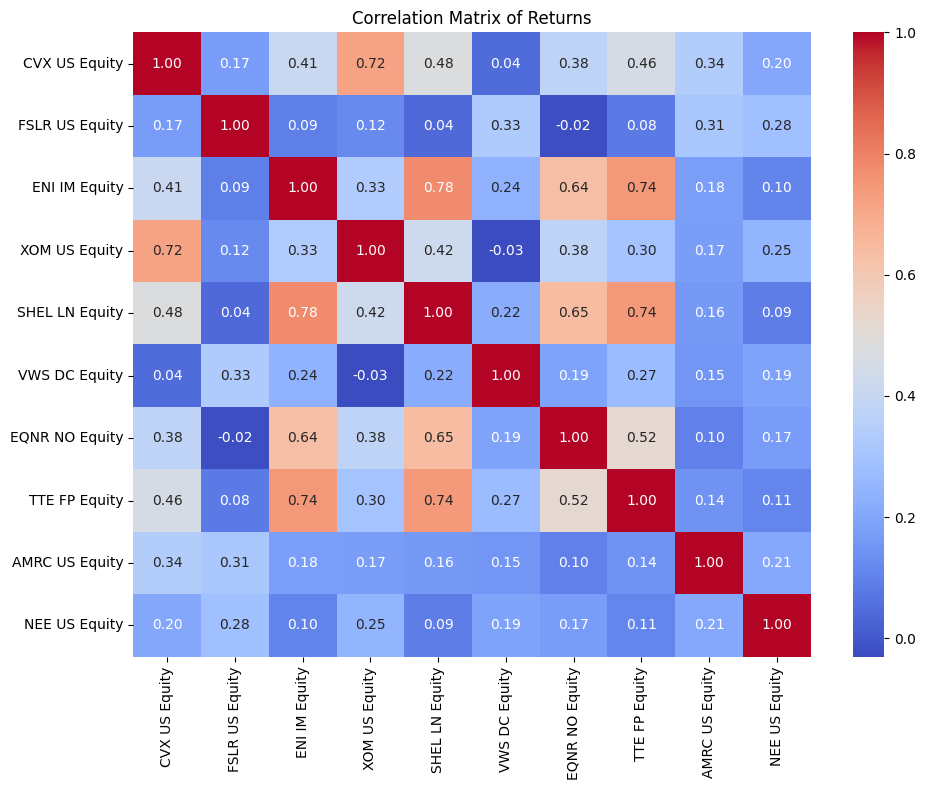

In [17]:
#| label: correlation_heatmap
corr_matrix = returns.corr(method = 'pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Matrix of Returns")
plt.tight_layout()


Text(0.5, 1.0, 'Difference in correlation Matrix of Returns')

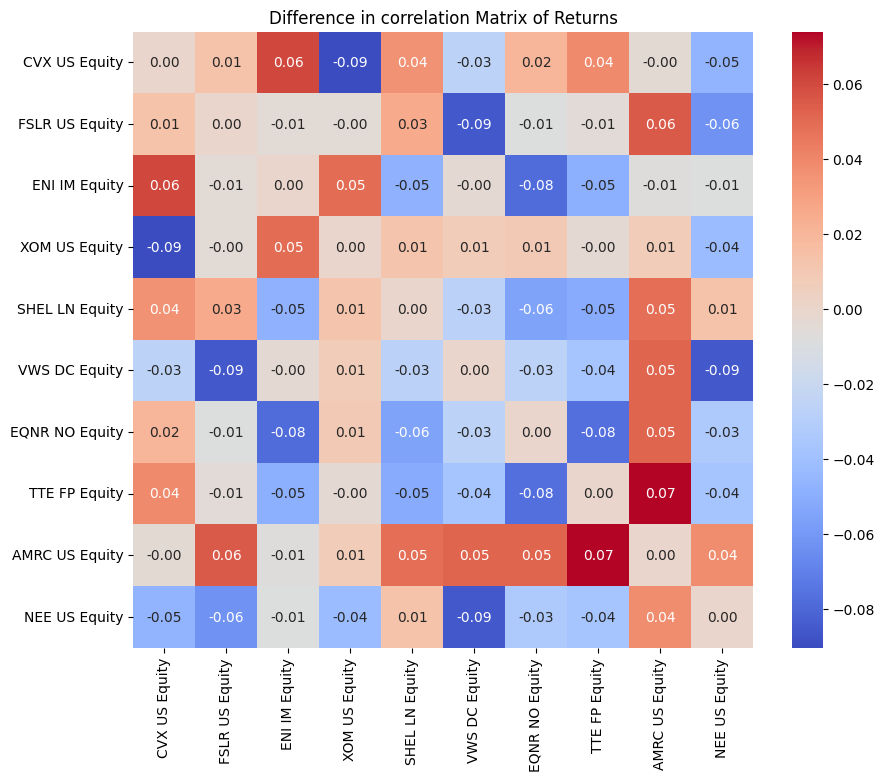

In [18]:
#| label: correlation_heatmap_difference
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(method = 'spearman') - returns.corr(method = 'pearson'), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Difference in correlation Matrix of Returns")


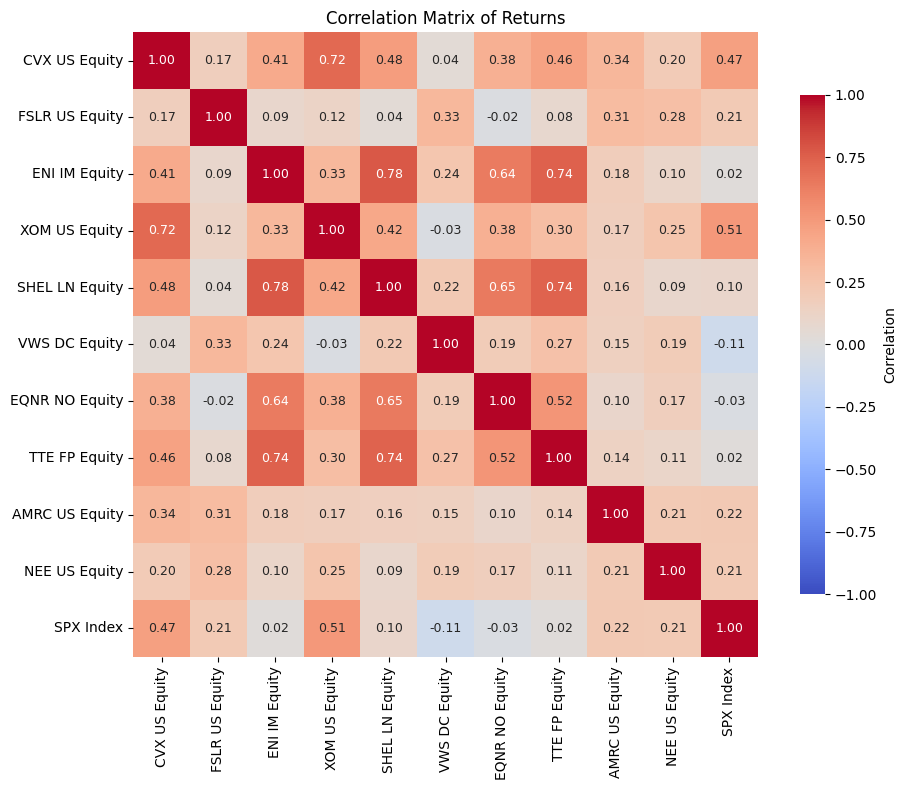

In [19]:
#| label: correlation_heatmap_all
plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(220, 20, as_cmap=True)  # alternative: sns.color_palette("vlag", as_cmap=True)

sns.heatmap(
    full_returns.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,      # force scale from -1 to 1
    center=0,             # center the diverging palette at 0
    annot_kws={"size": 9},
    square=True,
    linewidths=0.0,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

plt.title("Correlation Matrix of Returns")
plt.tight_layout()
plt.show()


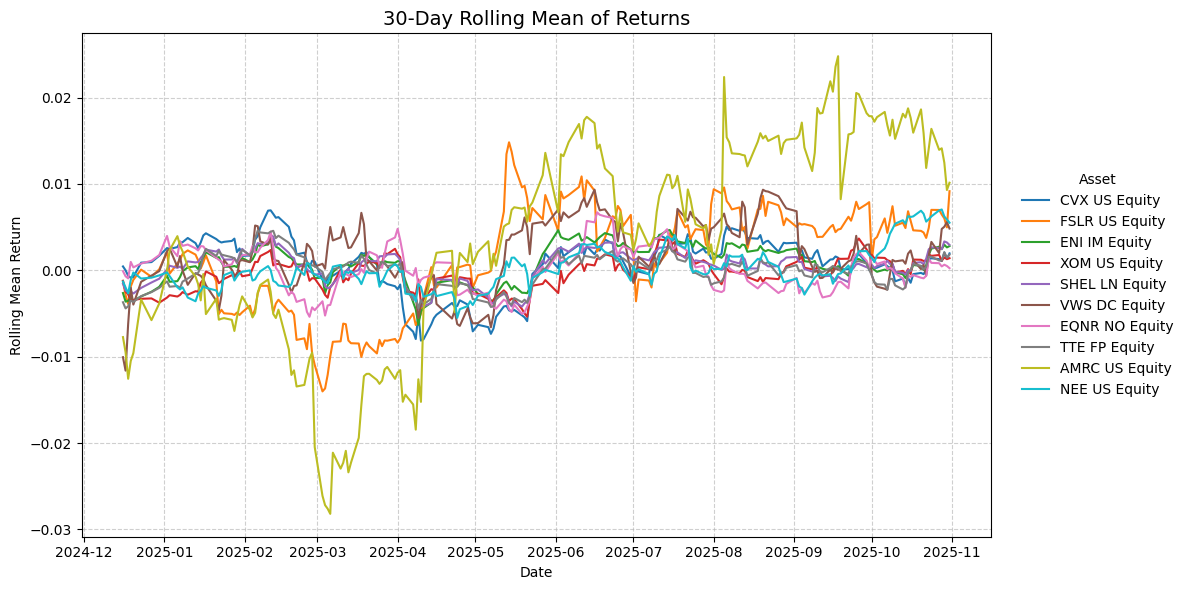

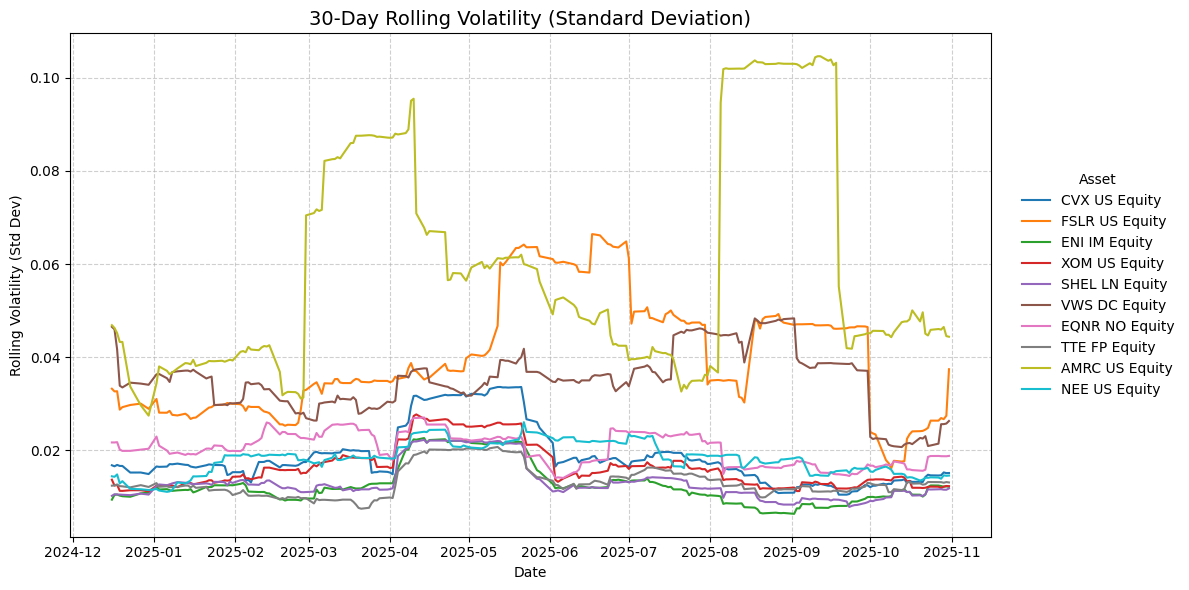

In [20]:
#| label: rolling_analysis_separate
import matplotlib.pyplot as plt
# Assuming 'returns' DataFrame is already defined, and 'window' is set to 30

window = 30
rolling_mean = returns.rolling(window=window).mean()
rolling_vol = returns.rolling(window=window).std()

# --- Chart 1: Rolling Mean ---
plt.figure(figsize=(12, 6))

for col in returns.columns:
    # Plotting each asset's rolling mean
    plt.plot(rolling_mean.index, rolling_mean[col], linewidth=1.5, label=col)

plt.title(f'{window}-Day Rolling Mean of Returns', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Rolling Mean Return')
plt.grid(True, linestyle='--', alpha=0.6)

# Legend for Chart 1
plt.legend(
    title='Asset',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5), # Moves the legend outside the plot area
    frameon=False # Ensure a background for the legend for clarity
)
plt.tight_layout() # Adjust layout to make room for the legend
plt.show()


# --- Chart 2: Rolling Volatility ---
plt.figure(figsize=(12, 6))

for col in returns.columns:
    # Plotting each asset's rolling volatility
    plt.plot(rolling_vol.index, rolling_vol[col], linewidth=1.5, label=col)

plt.title(f'{window}-Day Rolling Volatility (Standard Deviation)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Rolling Volatility (Std Dev)')
plt.grid(True, linestyle='--', alpha=0.6)

# Legend for Chart 2 (identical placement)
plt.legend(
    title='Asset',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)
plt.tight_layout()
plt.show()


# RATIOS

In [21]:
#| label: import_fundamentals
MKT = pd.read_excel(PATH, sheet_name = "MKTCAP")
PE = pd.read_excel(PATH, sheet_name = "PE")
EPS = pd.read_excel(PATH, sheet_name = "EPS")
ROA = pd.read_excel(PATH, sheet_name = "ROA")
ROE = pd.read_excel(PATH, sheet_name = "ROE")
ESG = pd.read_excel(PATH, sheet_name = "ESG")

quarters = PE["Date"]
company_columns = PE.columns[1:]


In [22]:
#| label: EPS_fundamentals_long
PE_long  =  PE.set_index('Date').stack().reset_index().rename(columns = {"level_1":"Company", 0:"PE"})
MKT_long = MKT.set_index('Date').stack().reset_index().rename(columns = {"level_1":"Company", 0:"MKT"})
EPS_long = EPS.set_index('Date').stack().reset_index().rename(columns = {"level_1":"Company", 0:"EPS"})
ROA_long = ROA.set_index('Date').stack().reset_index().rename(columns = {"level_1":"Company", 0:"ROA"})
ROE_long = ROE.set_index('Date').stack().reset_index().rename(columns = {"level_1":"Company", 0:"ROE"})
ESG_long = ESG.set_index('Date').stack().reset_index().rename(columns = {"level_1":"Company", 0:"ESG"})

df_panel = pd.merge(PE_long,  MKT_long, on=['Date', 'Company'])
df_panel = pd.merge(df_panel, EPS_long, on=['Date', 'Company'])
df_panel.sort_values(['Company', 'Date'])


Date         Company       PE          MKT     EPS
18  Q1 2025  AMRC US Equity  18.6753     491.7470 -0.0794
28  Q2 2025  AMRC US Equity  18.9435     582.6516  0.1798
38  Q3 2025  AMRC US Equity  40.7588    1314.9483  0.2596
8   Q4 2024  AMRC US Equity  35.7656     983.5896  0.5543
10  Q1 2025   CVX US Equity  23.4966  226783.8792  1.5960
20  Q2 2025   CVX US Equity  23.6984  182343.6950  1.0861
30  Q3 2025   CVX US Equity  27.0581  236228.3970  1.3572
0   Q4 2024   CVX US Equity  17.5221  207916.5329  1.4443
12  Q1 2025   ENI IM Equity  18.7783   37689.4974  0.3008
22  Q2 2025   ENI IM Equity  19.0738   37139.5564  0.1359
32  Q3 2025   ENI IM Equity  18.3212   40864.1228  0.2166
2   Q4 2024   ENI IM Equity  16.9689   35622.1154  0.0345
16  Q1 2025  EQNR NO Equity   8.3310   57323.5871  0.7702
26  Q2 2025  EQNR NO Equity   8.3402   51462.8834  0.3745
36  Q3 2025  EQNR NO Equity  11.5145   46373.2035 -0.0593
6   Q4 2024  EQNR NO Equity   7.4988   52084.9723  0.5699
11  Q1 2025  FSLR US Equity  10.1810   10487.2255  1.5563
21  Q2 2025  FSLR US Equity  13.3798   12945.3486  2.3894
31  Q3 2025  FSLR US Equity  16.0091   17572.8691  3.1519
1   Q4 2024  FSLR US Equity  13.9387   15071.3753  2.8651
19  Q1 2025   NEE US Equity  19.8611  112979.4631  0.3256
29  Q2 2025   NEE US Equity  18.6761  104207.5043  0.7415
39  Q3 2025   NEE US Equity  19.6291  115503.3788  0.8751
9   Q4 2024   NEE US Equity  22.2759  117759.9181  0.4528
14  Q1 2025  SHEL LN Equity  16.7258  169983.4394  0.6273
24  Q2 2025  SHEL LN Equity  15.6333  150971.7067  0.4569
34  Q3 2025  SHEL LN Equity  14.4794  153793.5592  0.6749
4   Q4 2024  SHEL LN Equity  12.2518  151408.1715  0.1171
17  Q1 2025   TTE FP Equity  10.8453  113449.0273  1.3419
27  Q2 2025   TTE FP Equity  11.0459  101444.4930  0.8839
37  Q3 2025   TTE FP Equity   9.7443   99711.8954  1.2237
7   Q4 2024   TTE FP Equity   8.2712  105783.2996  1.3439
15  Q1 2025   VWS DC Equity  22.2552   10762.7300  0.0000
25  Q2 2025   VWS DC Equity  16.7213   11032.0113  0.0255
35  Q3 2025   VWS DC Equity  17.2261   14157.8123  0.2600
5   Q4 2024   VWS DC Equity  26.2158   11004.1938  0.5008
13  Q1 2025   XOM US Equity  15.8763  399825.1447  1.3975
23  Q2 2025   XOM US Equity  15.4197  338762.6257  1.2284
33  Q3 2025   XOM US Equity  16.7982  357144.7371  1.3053
3   Q4 2024   XOM US Equity  13.8069  377650.2270  1.3428

In [23]:
#| label: ROA_fundamentals_ratios
df_panel_ratios = pd.merge(ROE_long, ROA_long, on=['Date', 'Company'])
df_panel_ratios = pd.merge(df_panel_ratios, ESG_long, on=['Date', 'Company'])
df_panel_ratios


Date         Company      ROE      ROA   ESG
0  Q3 2025   CVX US Equity   7.3794   4.3597  3.03
1  Q3 2025  FSLR US Equity  16.8639  11.2505  5.57
2  Q3 2025   ENI IM Equity   5.2792   2.0033  7.09
3  Q3 2025   XOM US Equity  18.3731   6.5381  3.27
4  Q3 2025  SHEL LN Equity   8.0496   3.7868  3.51
5  Q3 2025   VWS DC Equity  29.4007   3.8371  5.11
6  Q3 2025  EQNR NO Equity  13.4925   4.2264  2.19
7  Q3 2025   TTE FP Equity  12.2564   4.9229  6.53
8  Q3 2025  AMRC US Equity   6.3219   1.4984  1.68
9  Q3 2025   NEE US Equity  12.4760   3.3312  6.56

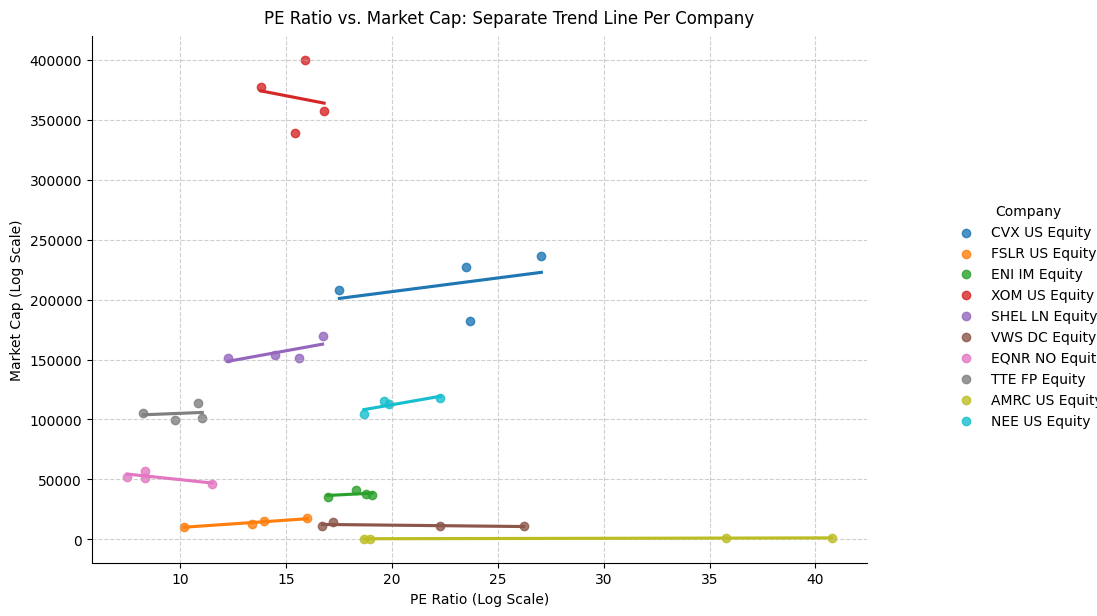

In [24]:
#| label: lmplot_PE_MKT
#! melted data / panel for lmplot
g = sns.lmplot(
    data=df_panel,
    x='PE',
    y='MKT',
    hue='Company',           # color = company
    scatter=True,            # geom_point
    aspect=1.5,              # aspect ratio
    height=6,                # height
    ci= None                 # Set to None to hide the confidence band for cleaner look
)

# --- 3. Apply Log Scales and Final Formatting ---
# g.ax.set_xscale('log')
# g.ax.set_yscale('log')

# Re-label the axes to reflect the log scale
g.set_axis_labels("PE Ratio (Log Scale)", "Market Cap (Log Scale)")
g.fig.suptitle("PE Ratio vs. Market Cap: Separate Trend Line Per Company", y=1.02)
plt.grid(True, which="both", ls="--", alpha=0.6)
# Adjust the legend position
g.legend.set_title("Company")
g.legend.set_bbox_to_anchor((1.05, 0.5))



### Scatter with groups

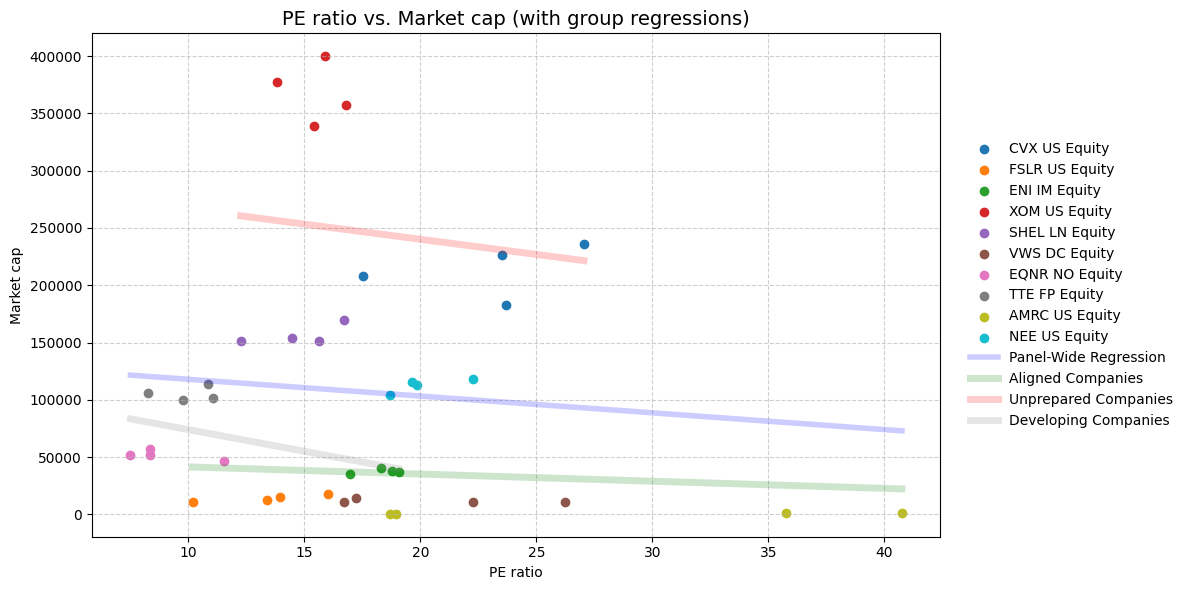

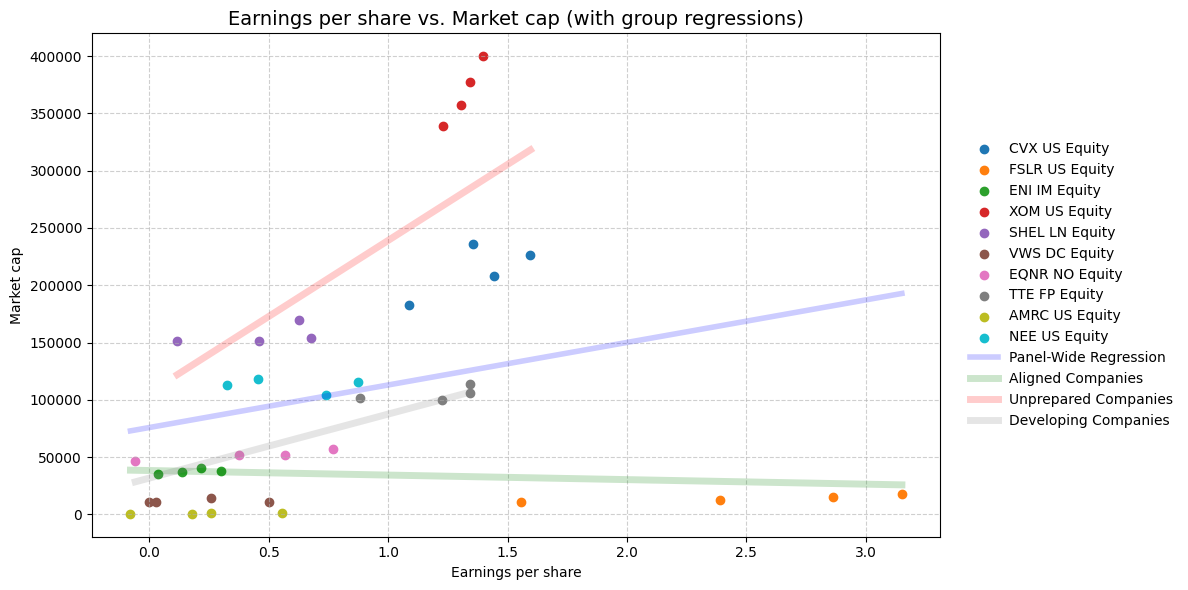

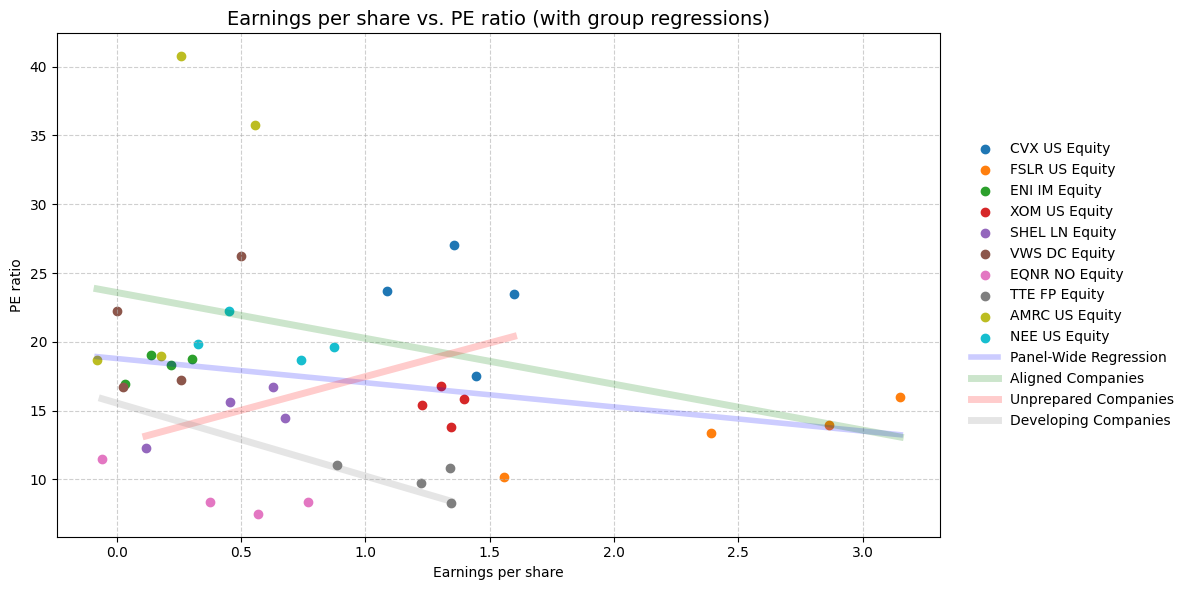

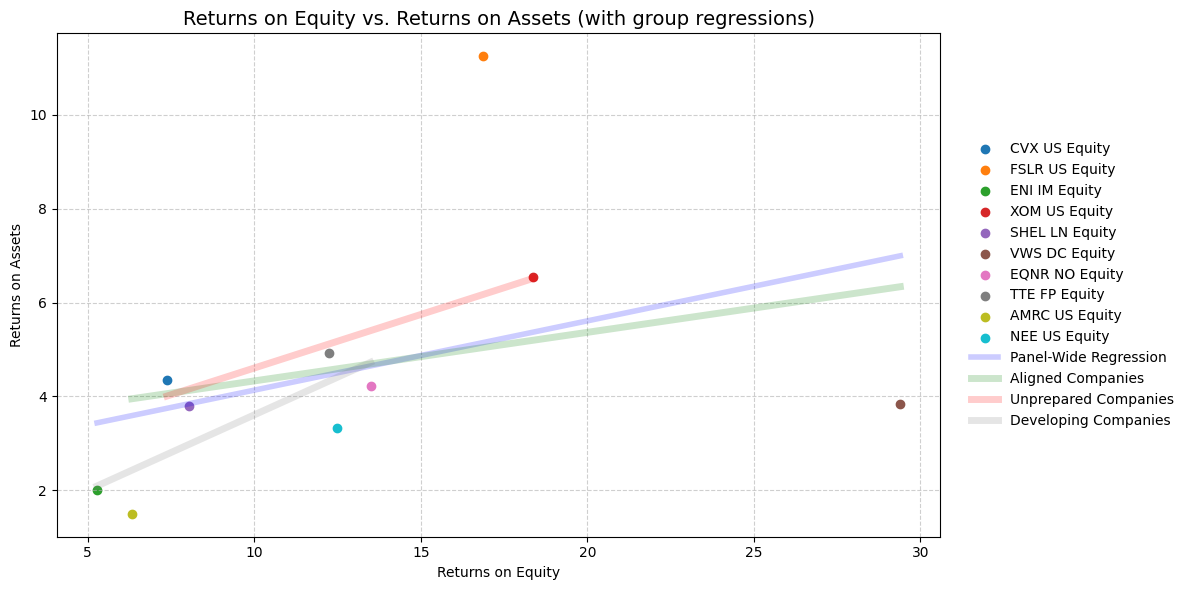

In [25]:
#| label: Scatter_with_groups
def Quick_scatter(Data1, Data2, label1, label2, ylog=False, xlog=False, panelreg = False, groupreg = True):
        # Collect all data for panel regression
    all_data1 = []
    all_data2 = []
    plt.figure(figsize=(12, 6))
    
    if groupreg:
    # ---- classify companies ----
        green_status = {
            "CVX US Equity": "no",
            "FSLR US Equity": "yes",
            "ENI IM Equity": "some",
            "XOM US Equity": "no",
            "SHEL LN Equity": "no",
            "VWS DC Equity": "yes",
            "EQNR NO Equity": "some",
            "TTE FP Equity": "some",
            "AMRC US Equity": "yes",
            "NEE US Equity": "yes"
        }


        # If you want: define green = yes only
        green_companies = [c for c,s in green_status.items() if s == "yes"]
        non_green_companies = [c for c,s in green_status.items() if s == "no"]
        some_companies = [c for c,s in green_status.items() if s == "some"]  # optional


        # Also prepare lists for green/non-green group regressions
        green_x = []
        green_y = []
        nongreen_x = []
        nongreen_y = []
        some_x = []
        some_y = []

    # --- Plot scatter + company-level regressions ---
    for company in company_columns:
        Data1_series = Data1[company]
        Data2_series = Data2[company]

        all_data1.append(Data1_series)
        all_data2.append(Data2_series)
        if groupreg:
            # Add to correct group
            if company in green_companies:
                green_x.append(Data1_series)
                green_y.append(Data2_series)
            elif company in non_green_companies:
                nongreen_x.append(Data1_series)
                nongreen_y.append(Data2_series)
            elif company in some_companies:
                some_x.append(Data1_series)
                some_y.append(Data2_series)

        # Company scatter
        plt.scatter(Data1_series, Data2_series, label=company)

        # Company individual regression
        # sns.regplot(
        #     x=Data1_series.values,
        #     y=Data2_series.values,
        #     scatter=False,
        #     ci=None,
        #     line_kws={'alpha': 0.6, 'linewidth': 1}
        # )

    # --- Convert group lists ---
    if groupreg:
        gx = pd.concat(green_x).values if green_x else None
        gy = pd.concat(green_y).values if green_y else None
        nx = pd.concat(nongreen_x).values if nongreen_x else None
        ny = pd.concat(nongreen_y).values if nongreen_y else None
        sx = pd.concat(some_x).values if some_x else None
        sy = pd.concat(some_y).values if some_y else None

    if panelreg:
        # --- Panel-wide regression ---
        all_x = pd.concat(all_data1).values
        all_y = pd.concat(all_data2).values
        sns.regplot(
            x=all_x, y=all_y,
            scatter=False, ci=None,
            label='Panel-Wide Regression',
            line_kws={'color': 'blue', 'linewidth': 4, 'alpha': 0.2}
        )

    if groupreg:
        # --- Group Regressions ---
        if gx is not None:
            sns.regplot(
                x=gx, y=gy,
                scatter=False, ci=None,
                label='Aligned Companies',
                line_kws={'color': 'green', 'linewidth': 5, 'alpha': 0.2}
            )

        if nx is not None:
            sns.regplot(
                x=nx, y=ny,
                scatter=False, ci=None,
                label='Unprepared Companies',
                line_kws={'color': 'red', 'linewidth': 5, 'alpha': 0.2}
            )

        if sx is not None:
            sns.regplot(
                x=sx, y=sy,
                scatter=False, ci=None,
                label='Developing Companies',
                line_kws={'color': 'gray', 'linewidth': 5, 'alpha': 0.2}
        )

    # --- Formatting ---
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

    plt.title(f'{label1} vs. {label2} (with group regressions)', fontsize=14)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.grid(True, ls="--", alpha=0.6)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.tight_layout()


Quick_scatter(PE, MKT, "PE ratio", "Market cap", ylog = False, panelreg = True)
Quick_scatter(EPS, MKT, "Earnings per share", "Market cap", ylog = False, panelreg = True)
Quick_scatter(EPS, PE, "Earnings per share", "PE ratio", panelreg = True)
Quick_scatter(ROE, ROA, "Returns on Equity", "Returns on Assets", panelreg = True)
# Quick_scatter_1reg(ESG, PE, "ESG score", "PE ratio")
# Quick_scatter_1reg(ESG, EPS, "ESG score", "Earnings per share")
# Quick_scatter_1reg(ESG, ROE, "ESG score", "Returns on Equity")
# Quick_scatter_1reg(ESG, ROA, "ESG score", "Returns on Assets")


### without panel regressions

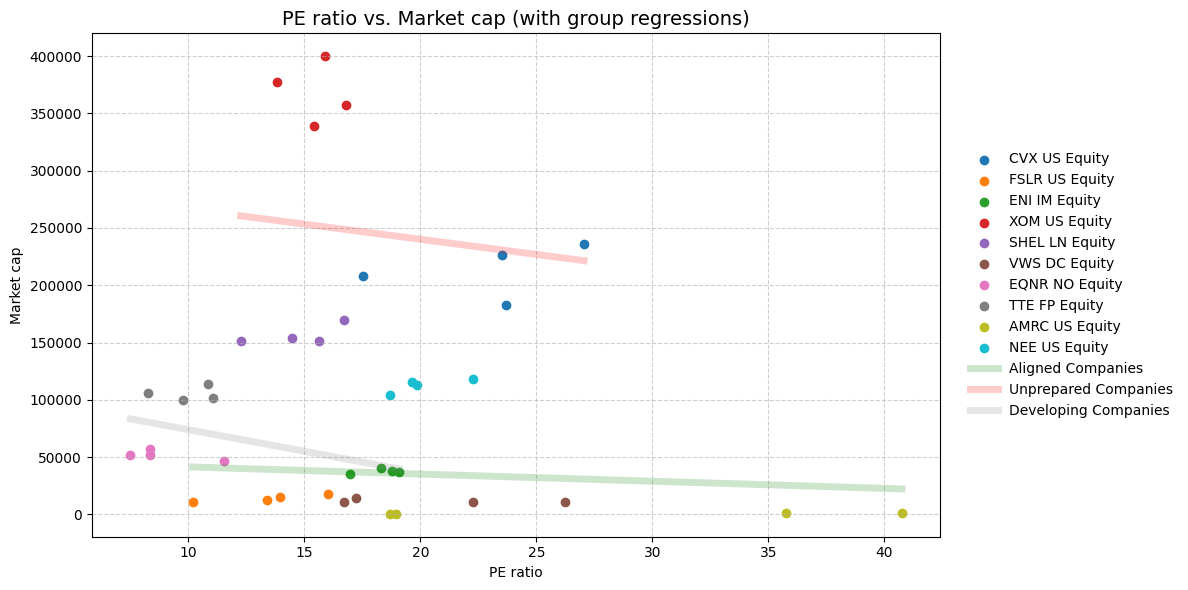

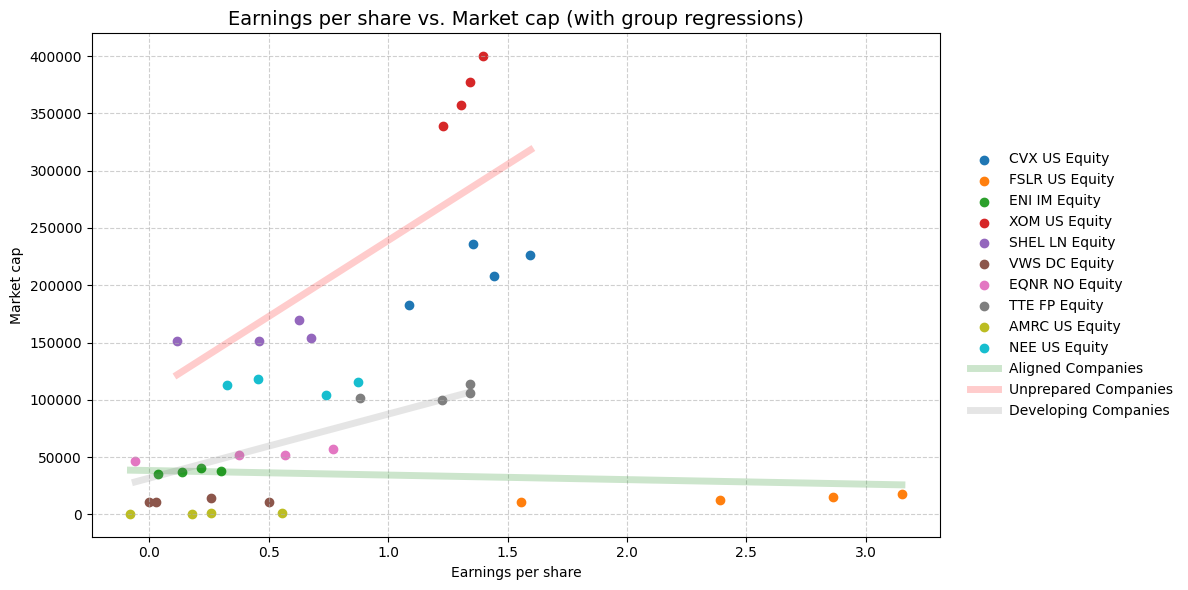

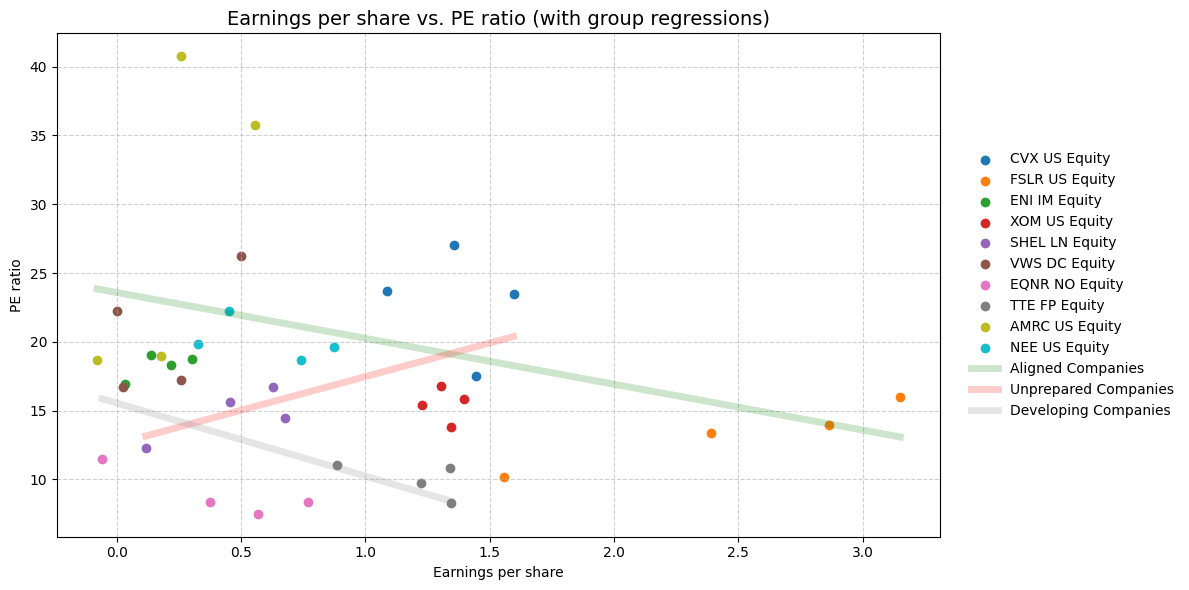

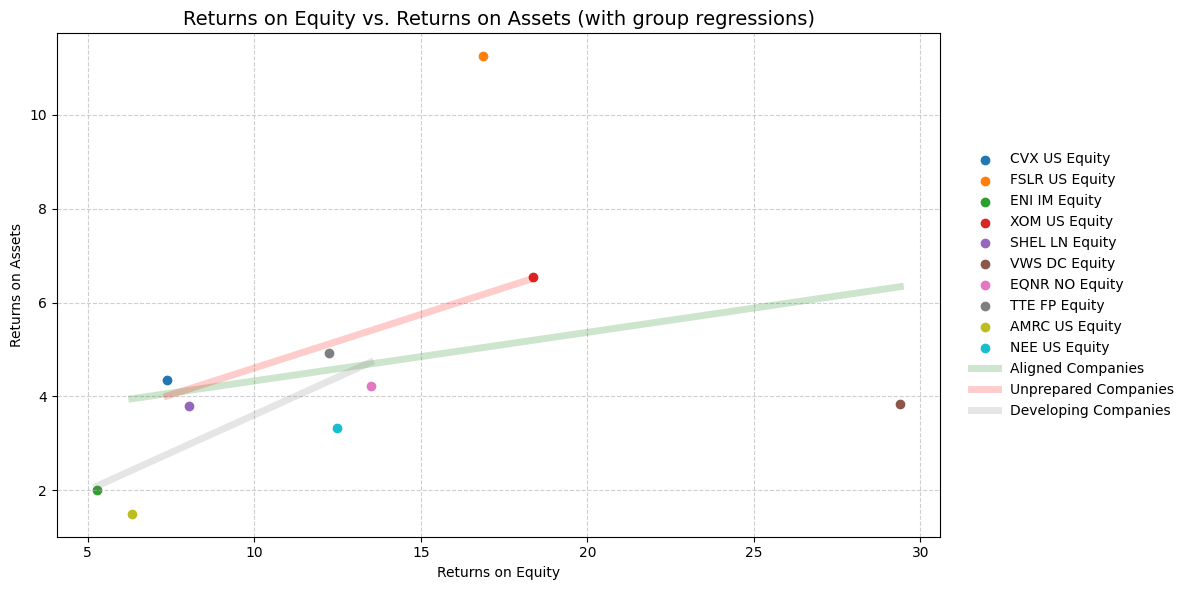

In [26]:
#| label: scatter_no_groups 
Quick_scatter(PE, MKT, "PE ratio", "Market cap")
Quick_scatter(EPS, MKT, "Earnings per share", "Market cap")
Quick_scatter(EPS, PE, "Earnings per share", "PE ratio")
Quick_scatter(ROE, ROA, "Returns on Equity", "Returns on Assets")


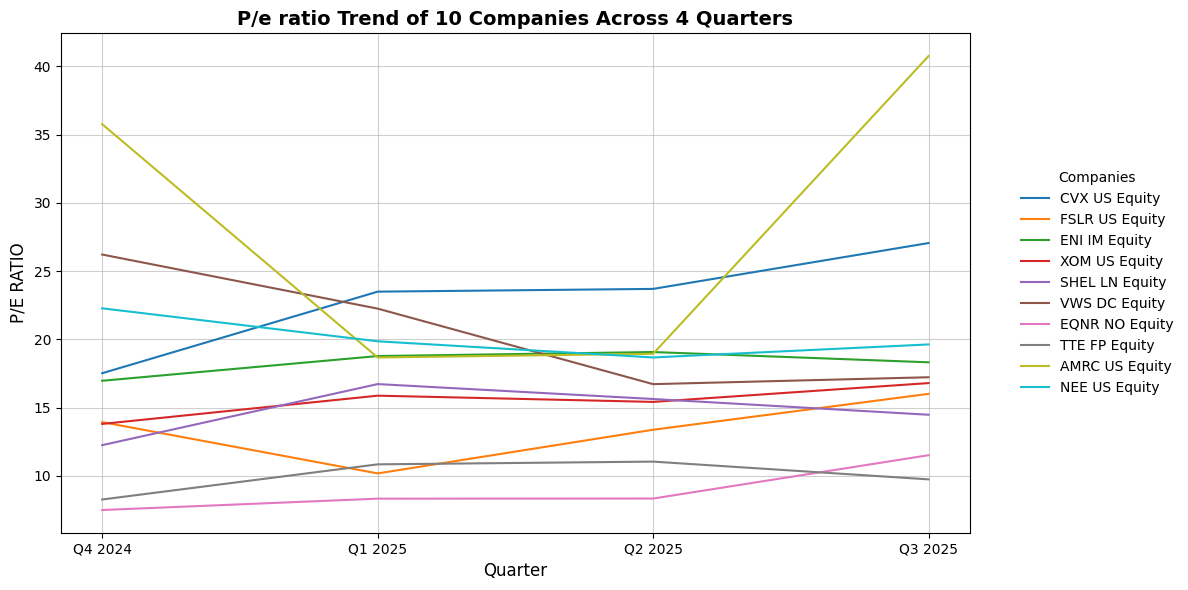

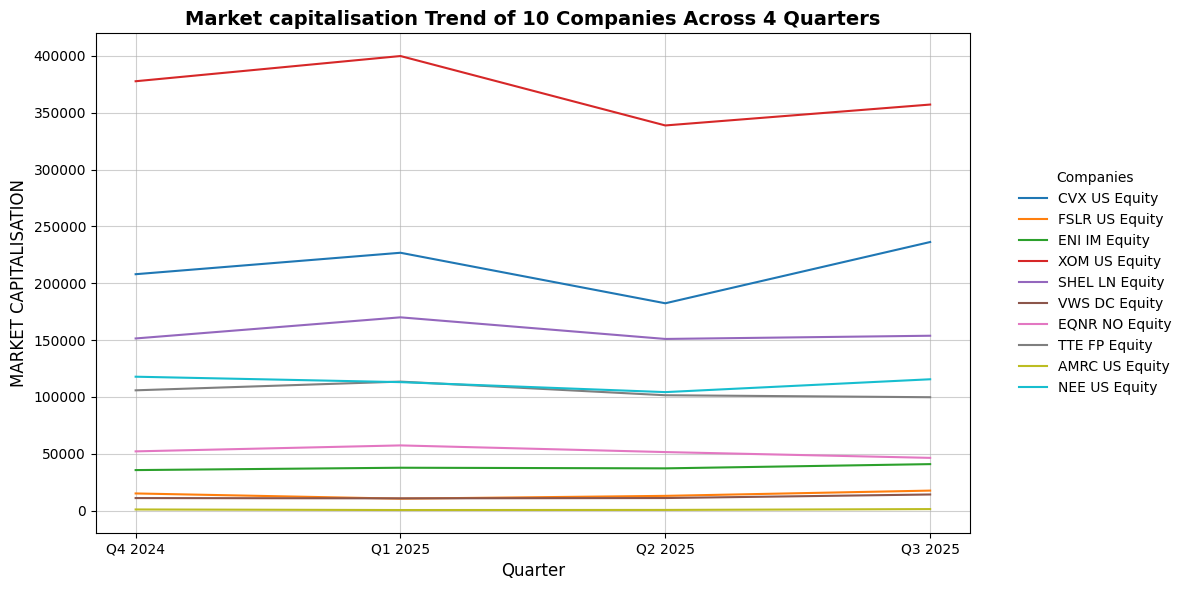

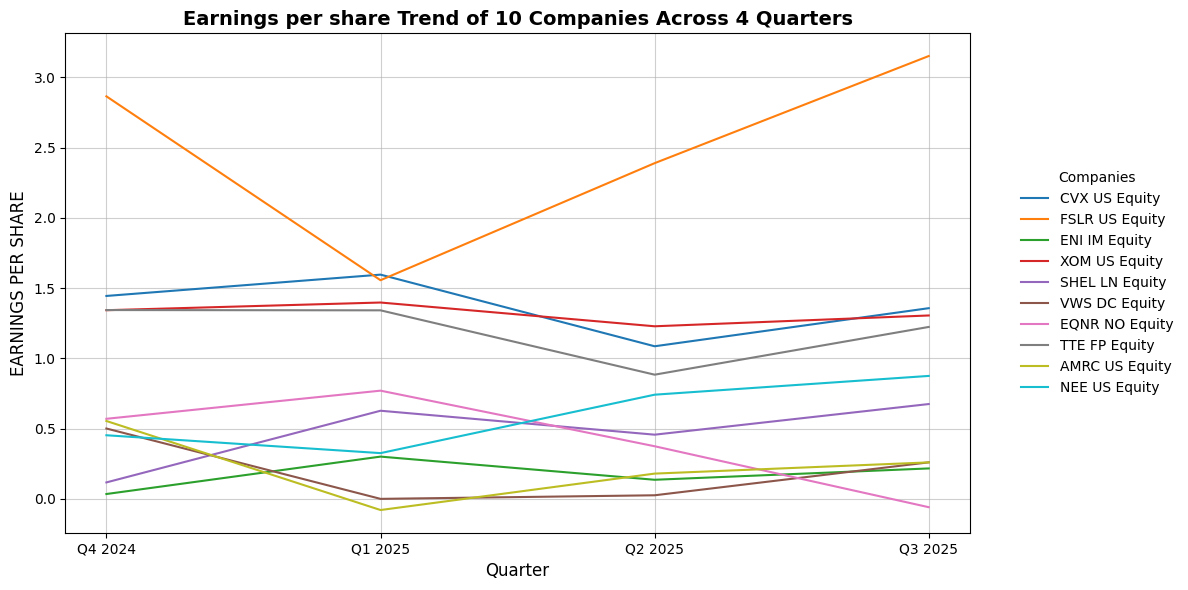

In [27]:
#| label: Timeseries 
def basic_plot(data, NAME):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot all columns (companies) against the index (quarters)
    # This is much simpler than the bar chart, as Matplotlib handles the
    # X-axis scaling automatically for line plots on an index.
    data.plot(kind='line', ax=ax)

    # --- 3. CUSTOMIZING THE CHART ---

    # Add titles and labels
    ax.set_xlabel("Quarter", fontsize=12)
    ax.set_ylabel(NAME.upper(), fontsize=12)
    ax.set_title(f"{NAME.capitalize()} Trend of 10 Companies Across 4 Quarters",
        fontsize=14,
        fontweight='bold'
    )

    # Customize the legend: place it outside the plot area
    ax.legend(
        title="Companies",
        bbox_to_anchor=(1.05, 0.5),
        loc='center left',
        borderaxespad=0,
        frameon=False
    )

    # Ensure only the quarter labels are shown on the X-axis
    ax.set_xticks(range(4))
    ax.set_xticklabels(quarters)

    # Add a grid for better readability
    ax.grid(axis='both', linestyle='-', alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()

basic_plot(PE, "P/E ratio")
basic_plot(MKT, "market capitalisation")
basic_plot(EPS, "Earnings per share")
# basic_plot(ROA, "return on assets")
# basic_plot(ROE, "return on equity")
# basic_plot(ESG, "Overall esg score")


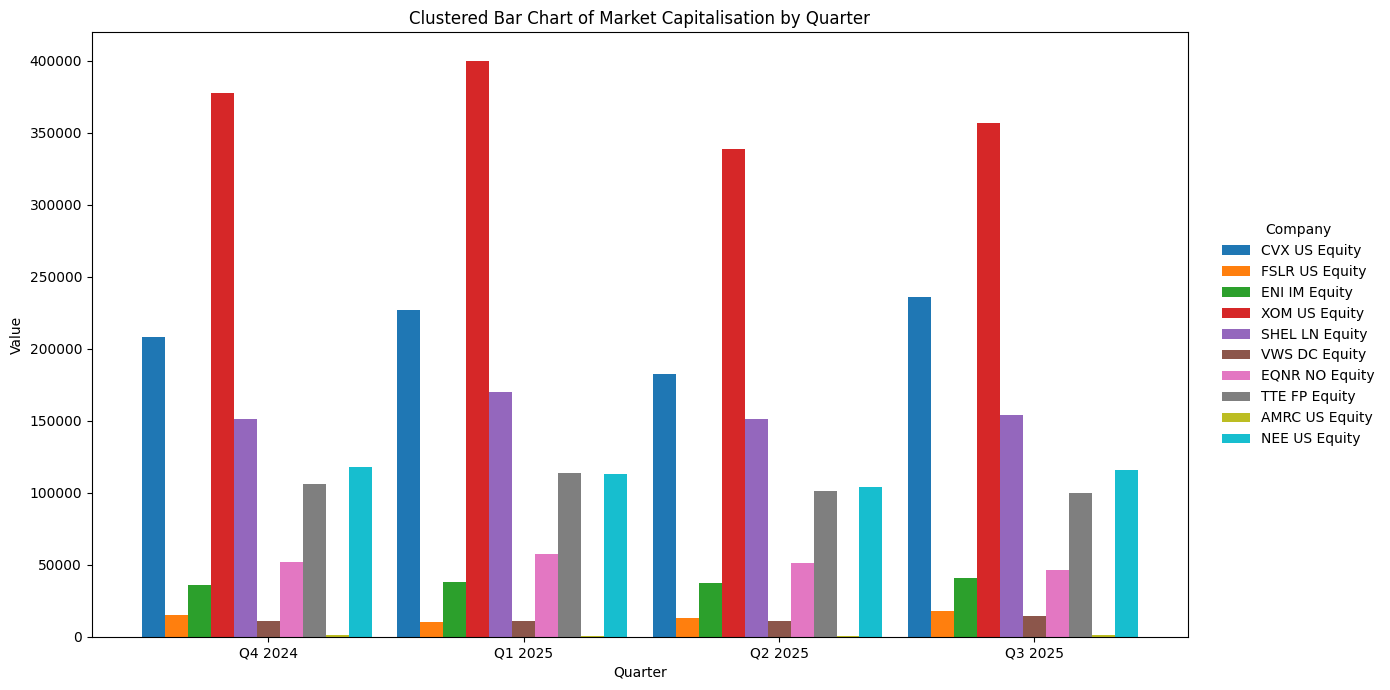

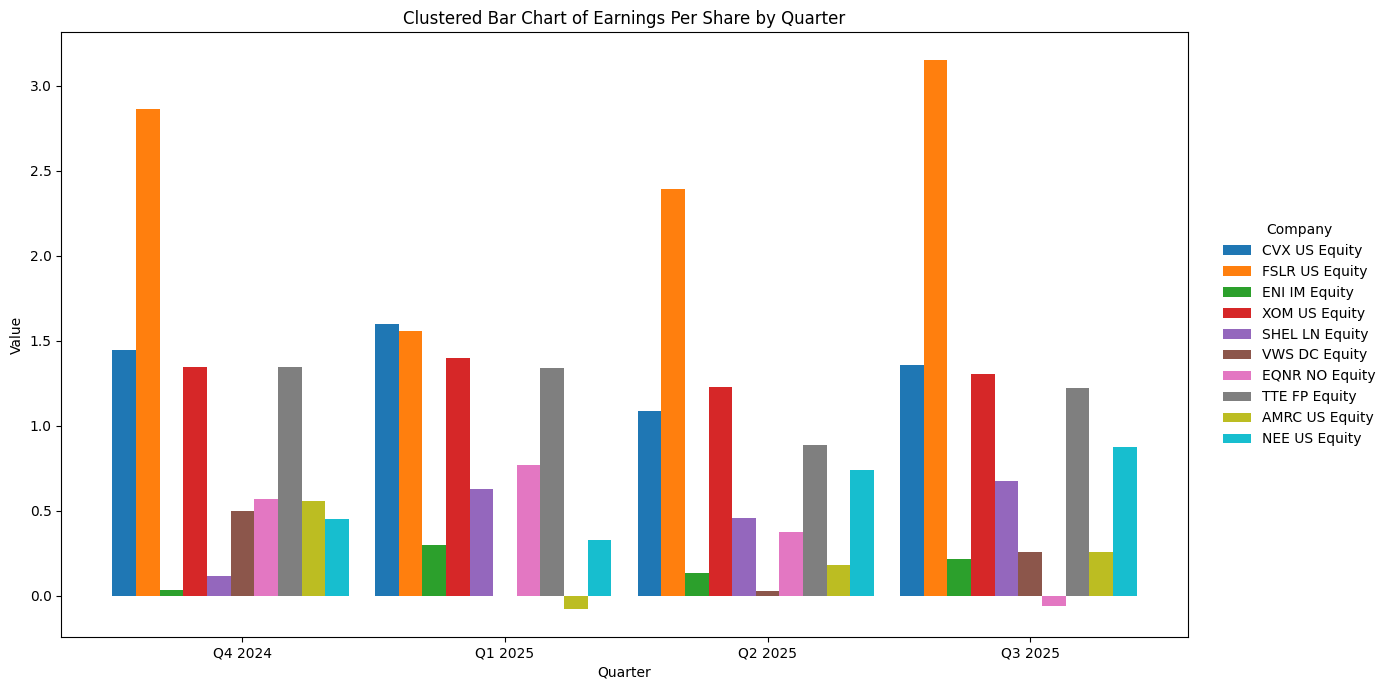

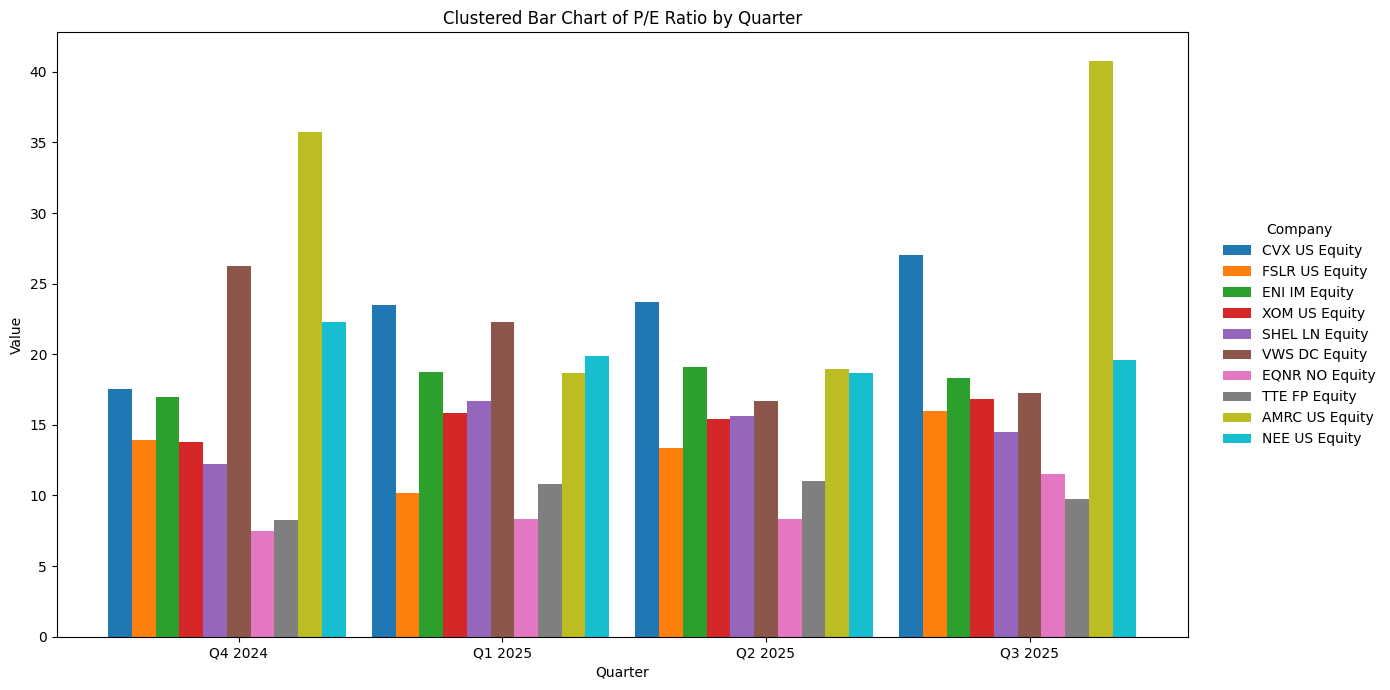

In [28]:
#| label: clustered_bar_chart
def clustered_bar_chart(df, name):
    quarters = ["Q4 2024", "Q1 2025", "Q2 2025", "Q3 2025"]
    plot_df = df.transpose().iloc[-10:]
    plot_df.columns = quarters
    companies = plot_df.index.tolist()

    x = np.arange(len(quarters))  # 4 quarter positions
    width = 0.09                  # small width because 10 companies inside each cluster

    plt.figure(figsize=(14, 7))

    for i, company in enumerate(companies):
        plt.bar(
            x + i*width,                         # shift inside each quarter cluster
            plot_df.loc[company, quarters],           # values for that company
            width,
            label=company,     # show legend only once
        )

    # Fix x-axis tick positions (center the cluster labels)
    plt.xticks(x + width*len(companies)/2, quarters)

    plt.xlabel("Quarter")
    plt.ylabel("Value")
    plt.title(f"Clustered Bar Chart of {name} by Quarter")
    plt.legend(title="Company", loc='center left',bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=False)
    plt.tight_layout()
    plt.show()

clustered_bar_chart(MKT, "Market Capitalisation")
clustered_bar_chart(EPS, "Earnings Per Share")
clustered_bar_chart(PE, "P/E Ratio")


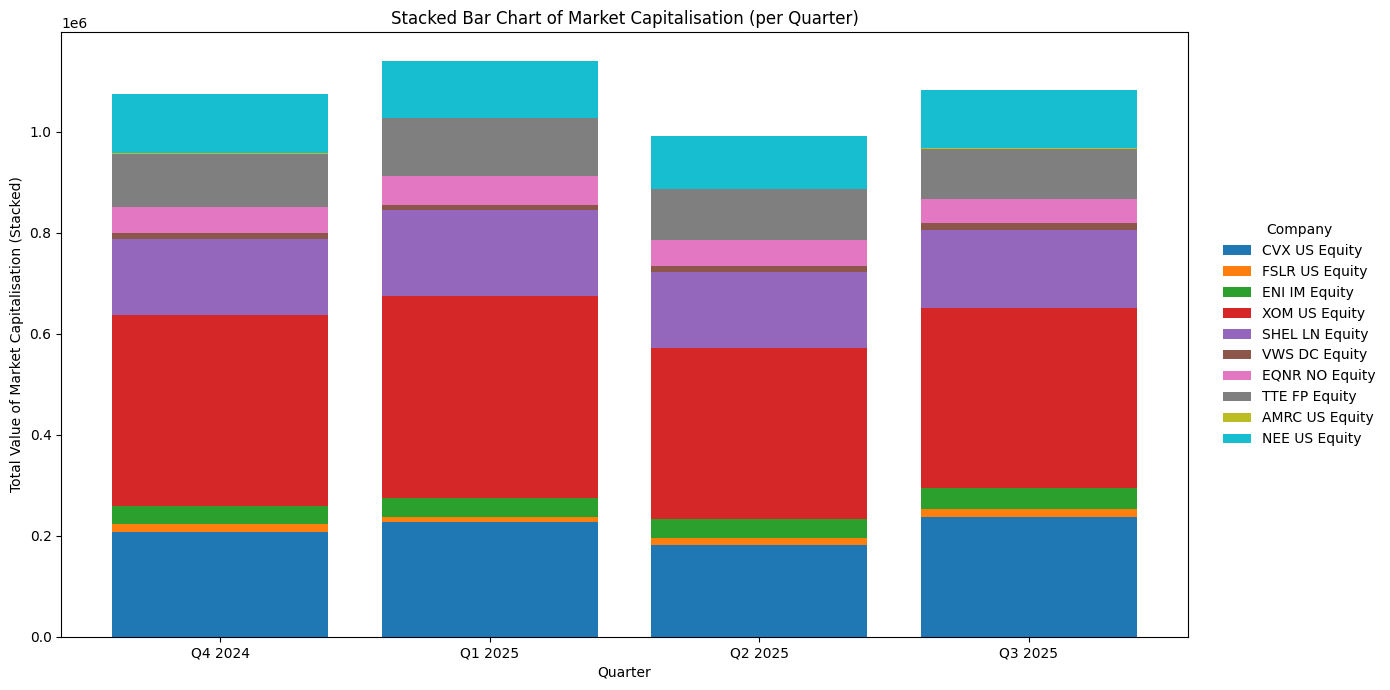

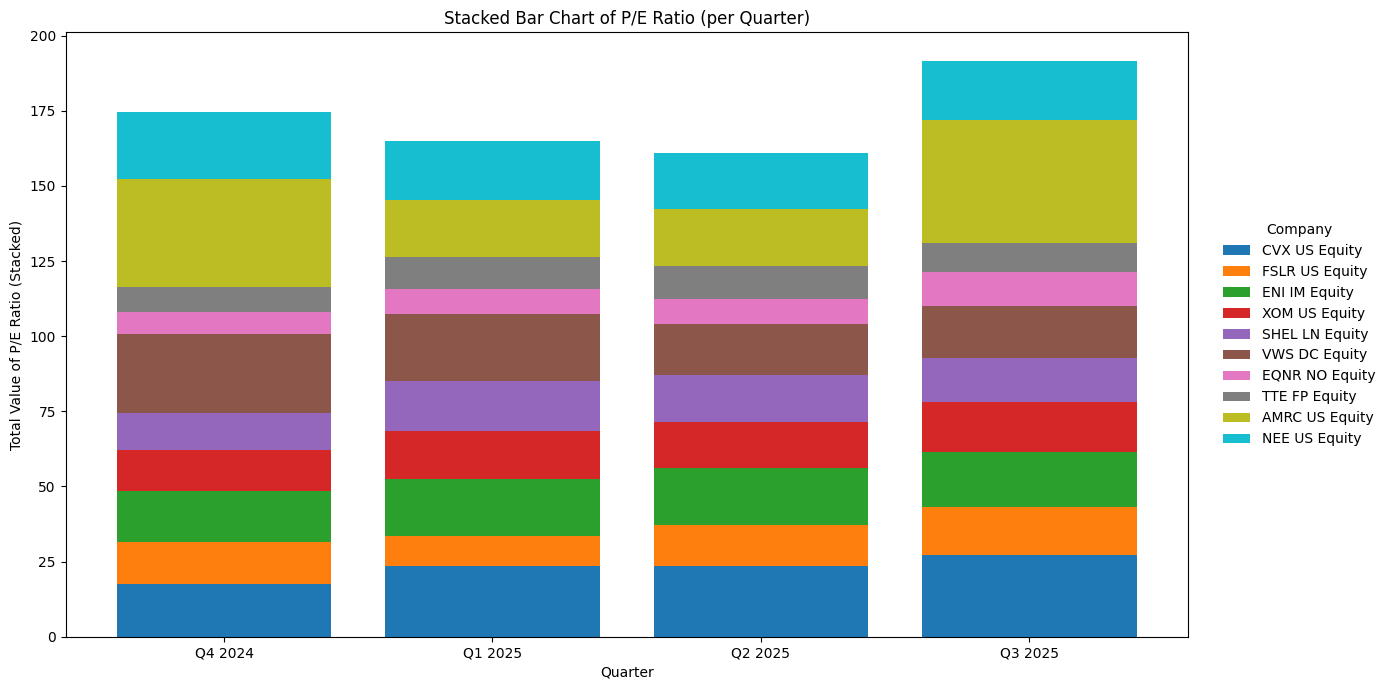

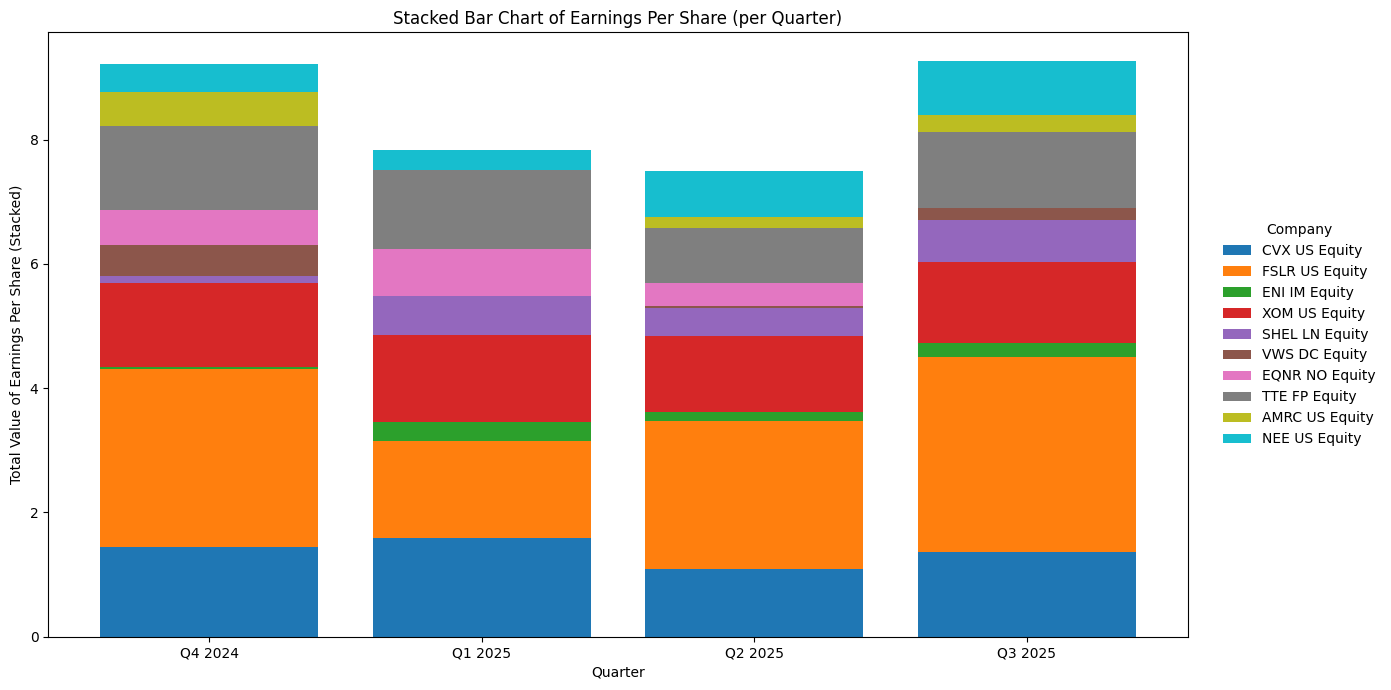

In [29]:
#| label: stacked_bar_chart
def stacked_bar_chart(df, name):
    quarters = ["Q4 2024", "Q1 2025", "Q2 2025", "Q3 2025"]
    plot_df = df.transpose().iloc[-10:]
    plot_df.columns = quarters
    companies = plot_df.index.tolist()

    # Convert all values to float
    plot_df = plot_df.apply(pd.to_numeric, errors="coerce")

    x = np.arange(len(quarters))

    plt.figure(figsize=(14,7))

    bottom = np.zeros(len(quarters), dtype=float)

    for company in companies:
    
        values = plot_df.loc[company, quarters].values.astype(float)

        plt.bar(
            x,
            values,
            bottom=bottom,
            label=company
        )
        bottom += values  # numeric safe

    plt.xticks(x, quarters)
    plt.xlabel("Quarter")
    plt.ylabel(f"Total Value of {name} (Stacked)")
    plt.title(f"Stacked Bar Chart of {name} (per Quarter)")
    plt.legend(title="Company", loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.tight_layout()
    plt.show()


stacked_bar_chart(MKT, "Market Capitalisation")
stacked_bar_chart(PE, "P/E Ratio")
stacked_bar_chart(EPS, "Earnings Per Share")


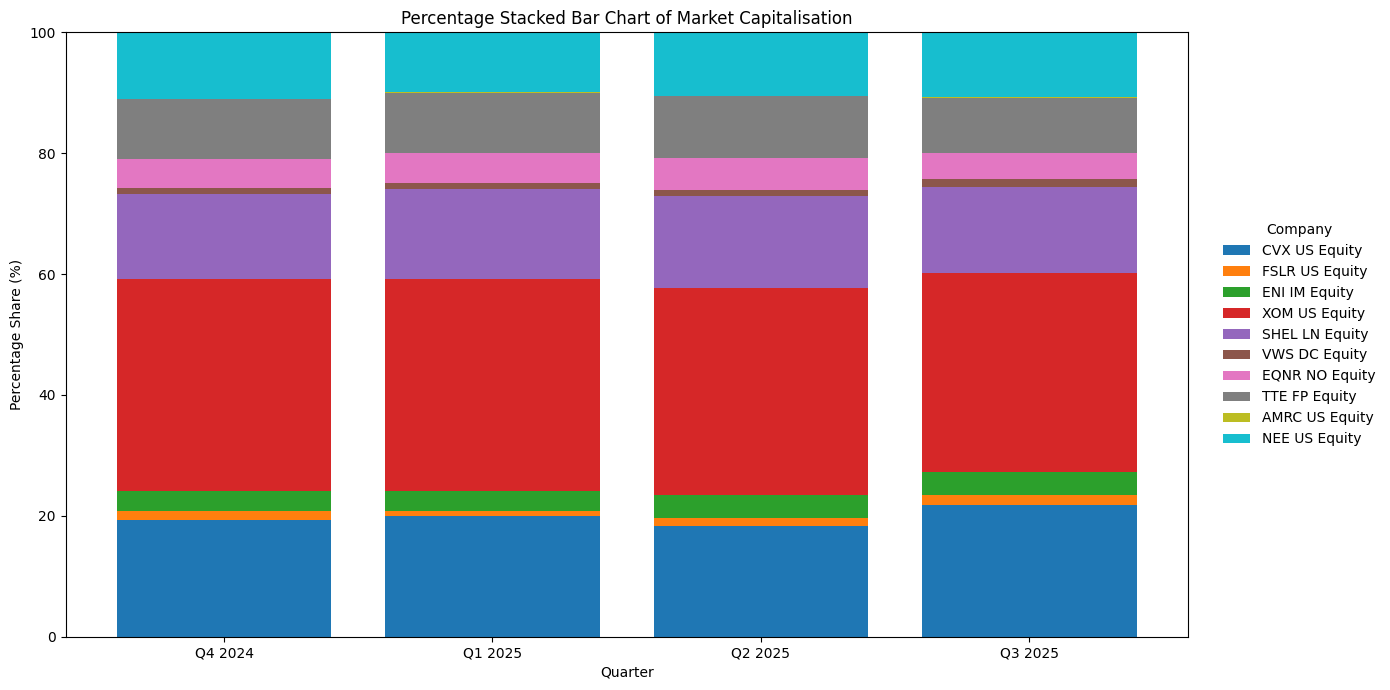

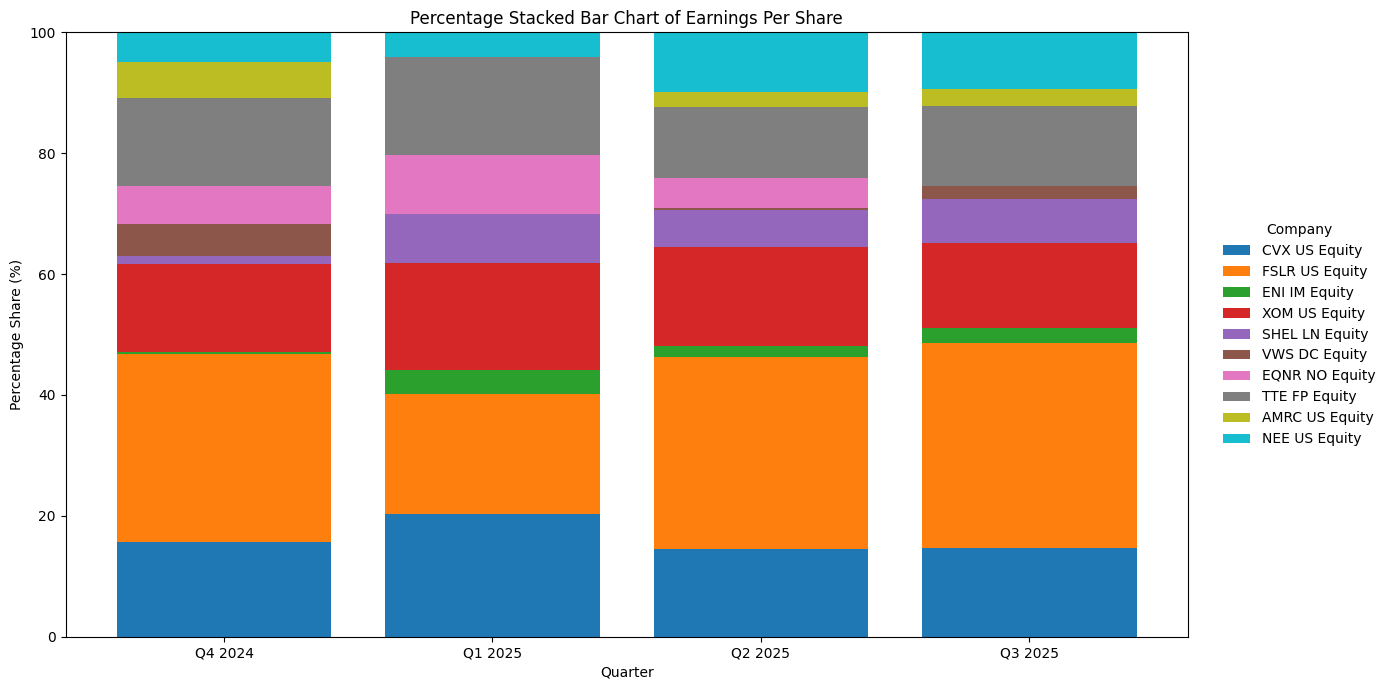

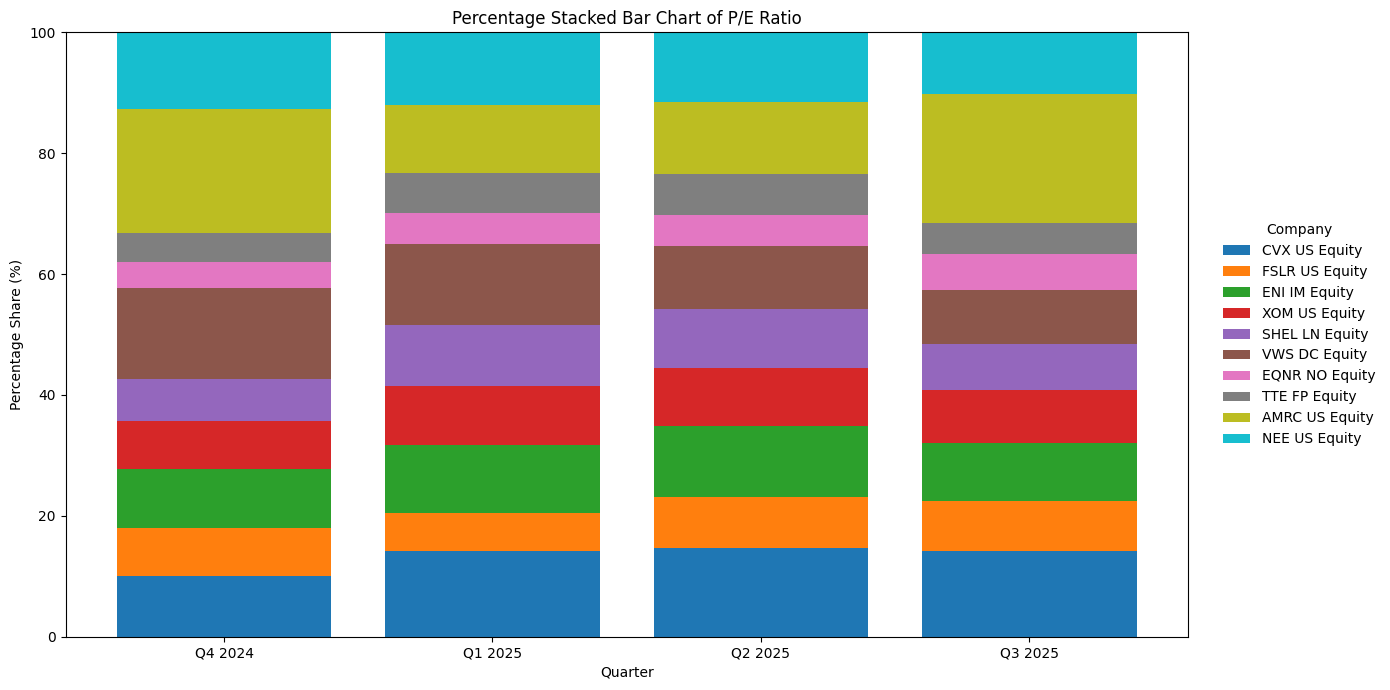

In [30]:
#| label: share_stacked_bar_chart
def percentage_stacked_bar_chart(df, name):
    quarters = ["Q4 2024", "Q1 2025", "Q2 2025", "Q3 2025"]
    plot_df = df.transpose().iloc[-10:]
    plot_df.columns = quarters
    companies = plot_df.index.tolist()

    # Convert to numeric
    plot_df = plot_df.apply(pd.to_numeric, errors="coerce")

    # Normalize so each column sums to 100

    df_pct = plot_df[quarters].div(plot_df[quarters].sum(axis=0), axis=1) * 100

    x = np.arange(len(quarters))

    plt.figure(figsize=(14,7))

    bottom = np.zeros(len(quarters))

    for company in companies:
        values = df_pct.loc[company, quarters].values.astype(float)

        plt.bar(
            x,
            values,
            bottom=bottom,
            label=company
        )
        bottom += values

    plt.xticks(x, quarters)
    plt.xlabel("Quarter")
    plt.ylabel("Percentage Share (%)")
    plt.title(f"Percentage Stacked Bar Chart of {name}")
    plt.legend(title="Company", loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=False)

    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

percentage_stacked_bar_chart(MKT, "Market Capitalisation")
percentage_stacked_bar_chart(EPS, "Earnings Per Share")
percentage_stacked_bar_chart(PE, "P/E Ratio")


## ESG

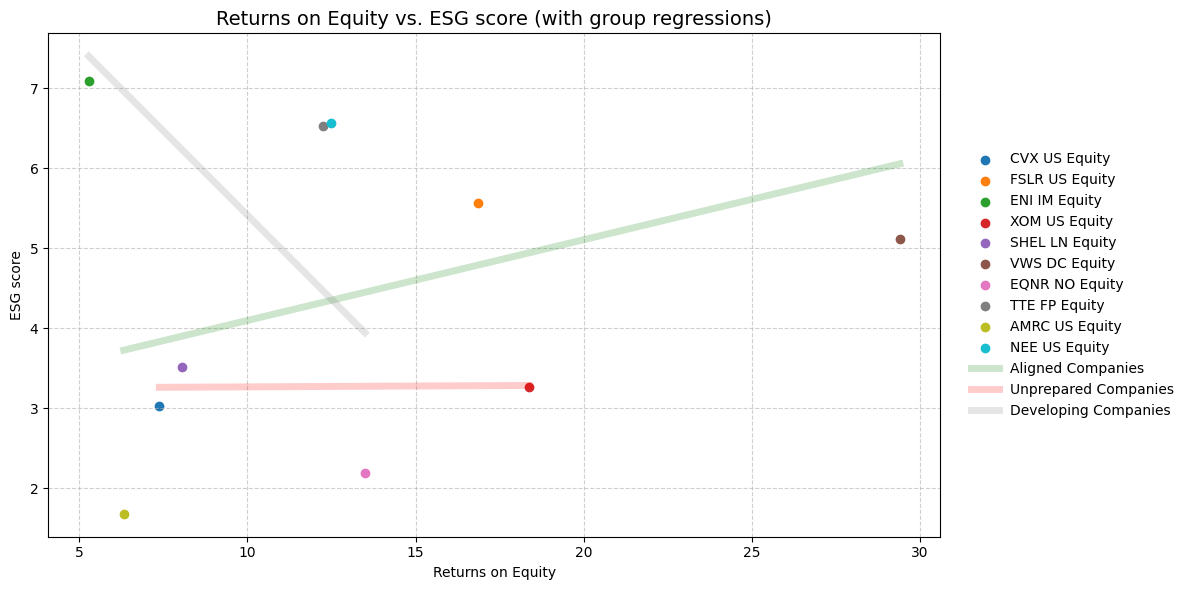

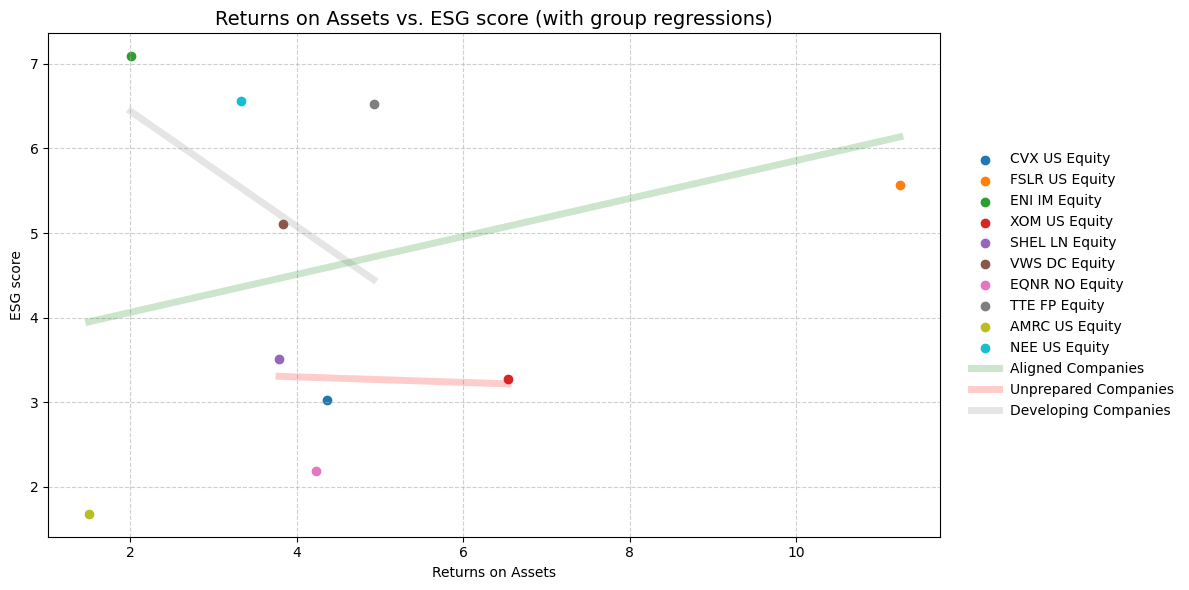

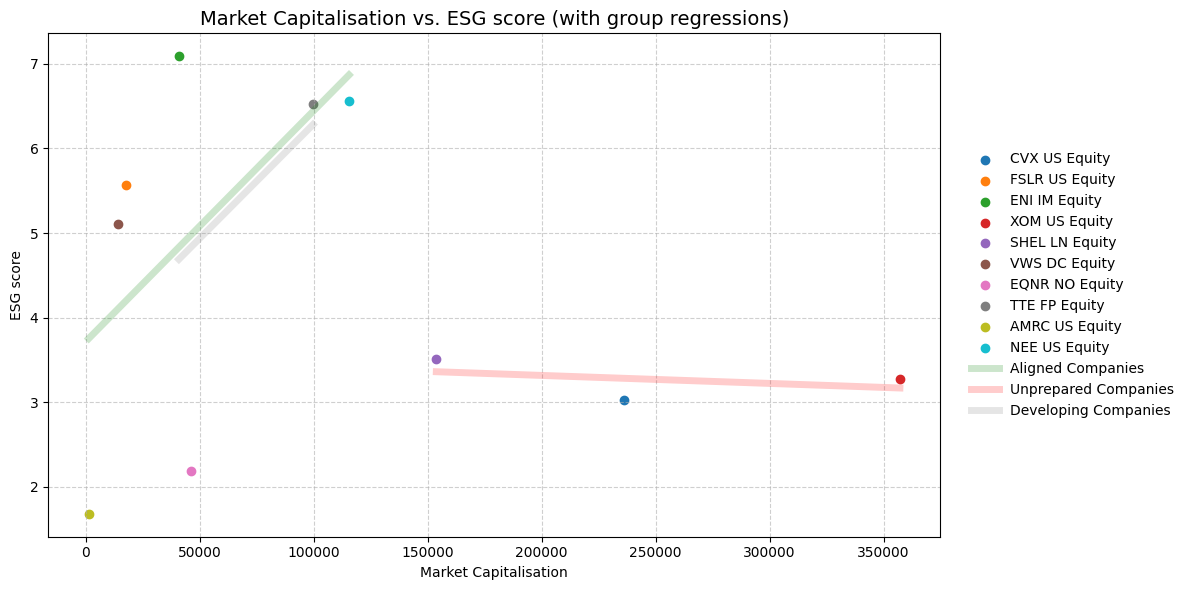

In [31]:
#| label: scatter_fundamentals_ESG
MKT2 = MKT.iloc[3:,:]
PE2 = PE.iloc[3:,:]
EPS2 = EPS.iloc[3:,:]

Quick_scatter(ROE, ESG, "Returns on Equity", "ESG score")
Quick_scatter(ROA, ESG, "Returns on Assets", "ESG score")
Quick_scatter(MKT2, ESG, "Market Capitalisation", "ESG score")


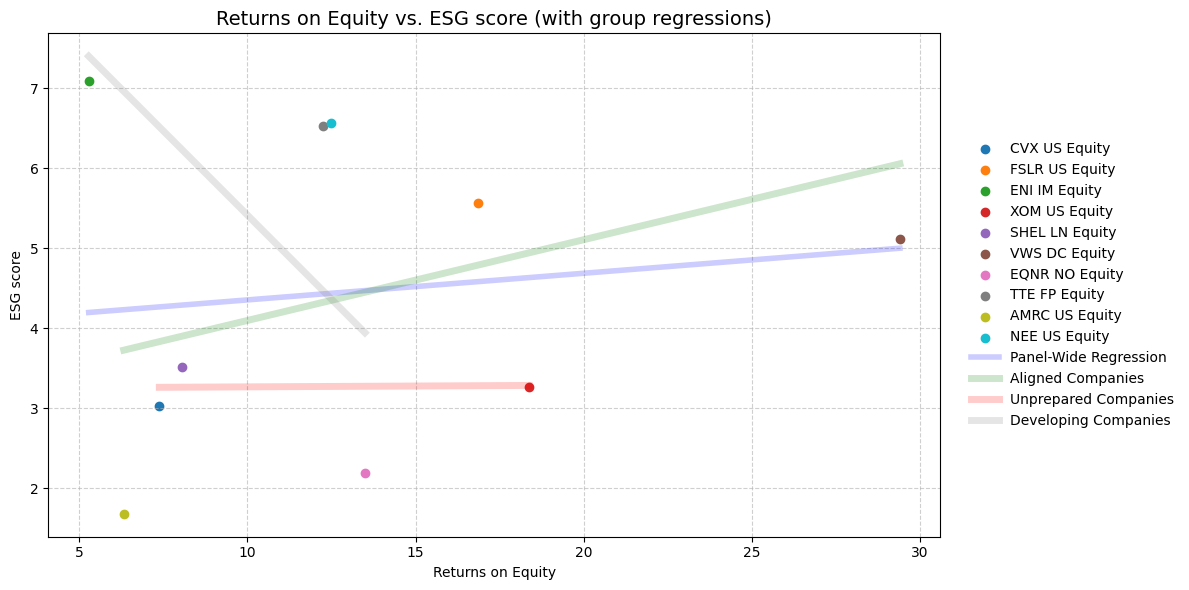

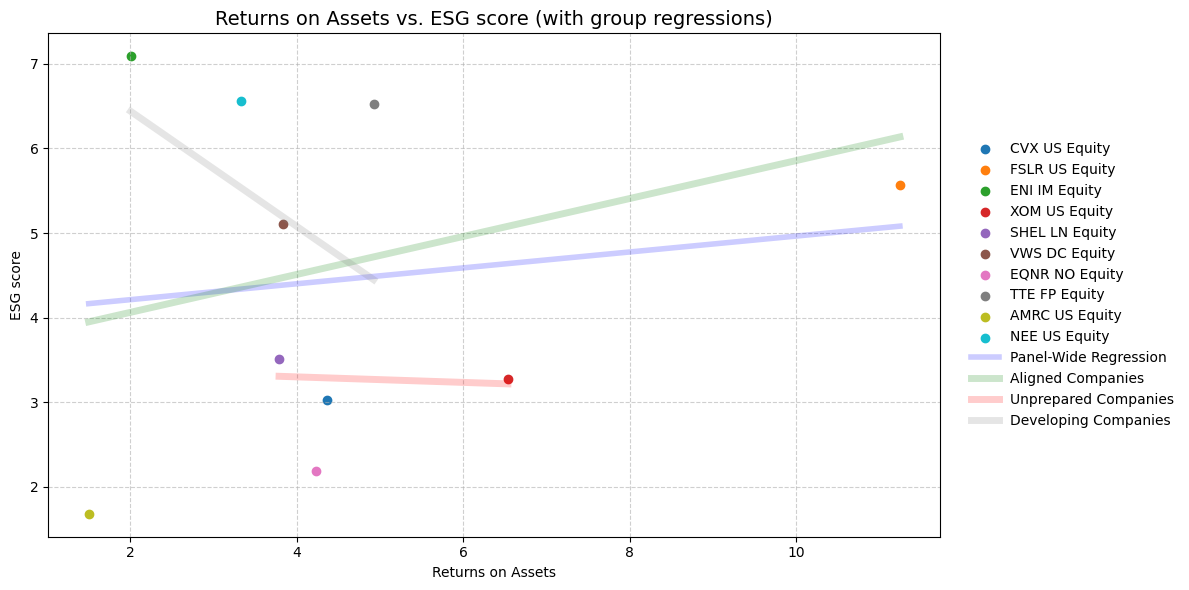

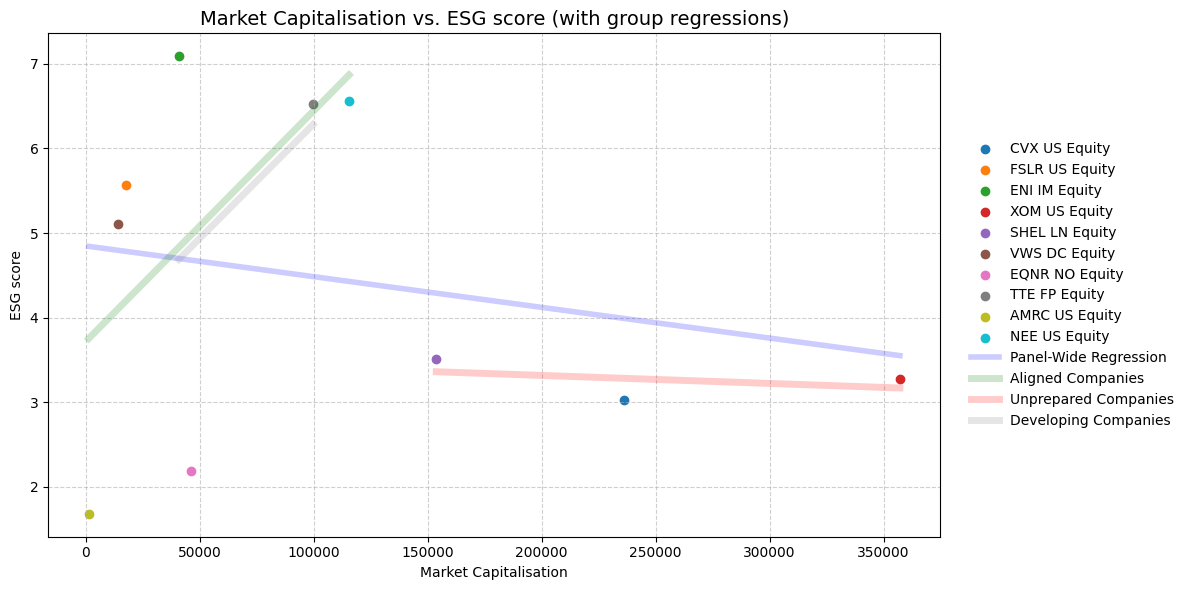

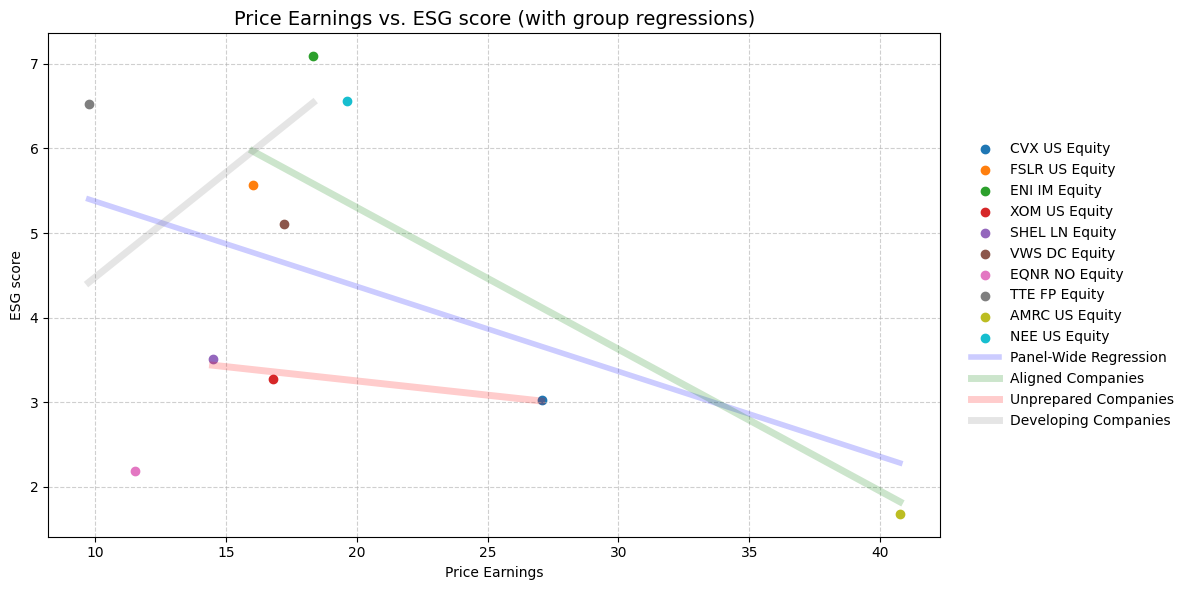

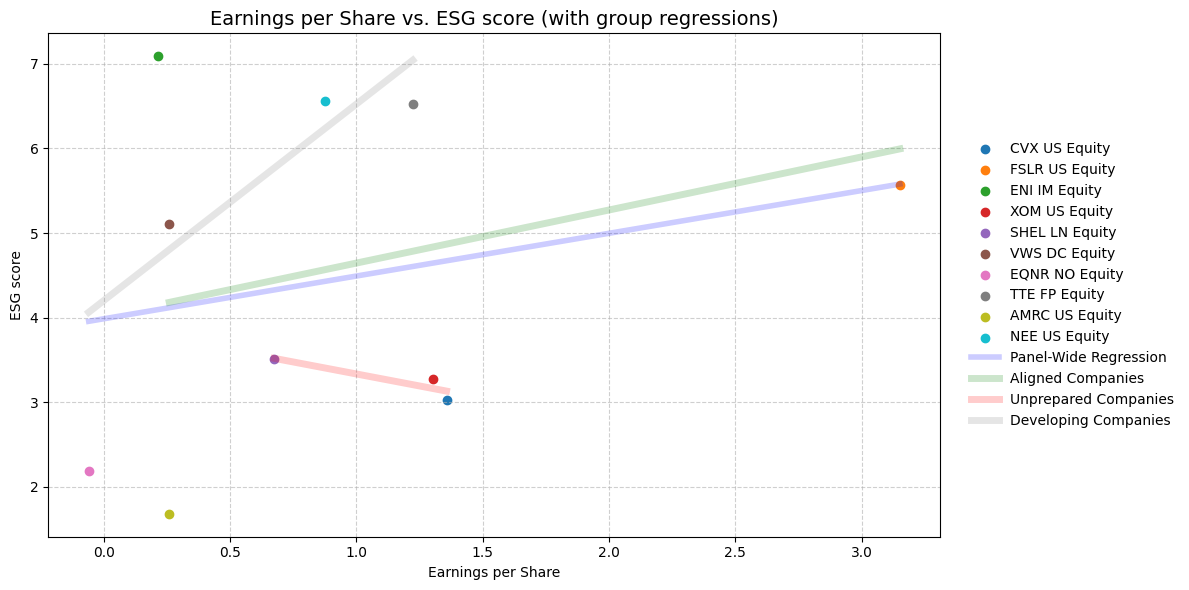

In [32]:
#| label: scatter_fundamentals_ESG_groups
Quick_scatter(ROE, ESG, "Returns on Equity", "ESG score", panelreg = True)
Quick_scatter(ROA, ESG, "Returns on Assets", "ESG score", panelreg = True)
Quick_scatter(MKT2, ESG, "Market Capitalisation", "ESG score", panelreg = True)
Quick_scatter(PE2, ESG, "Price Earnings", "ESG score", panelreg = True)
Quick_scatter(EPS2, ESG, "Earnings per Share", "ESG score", panelreg = True)


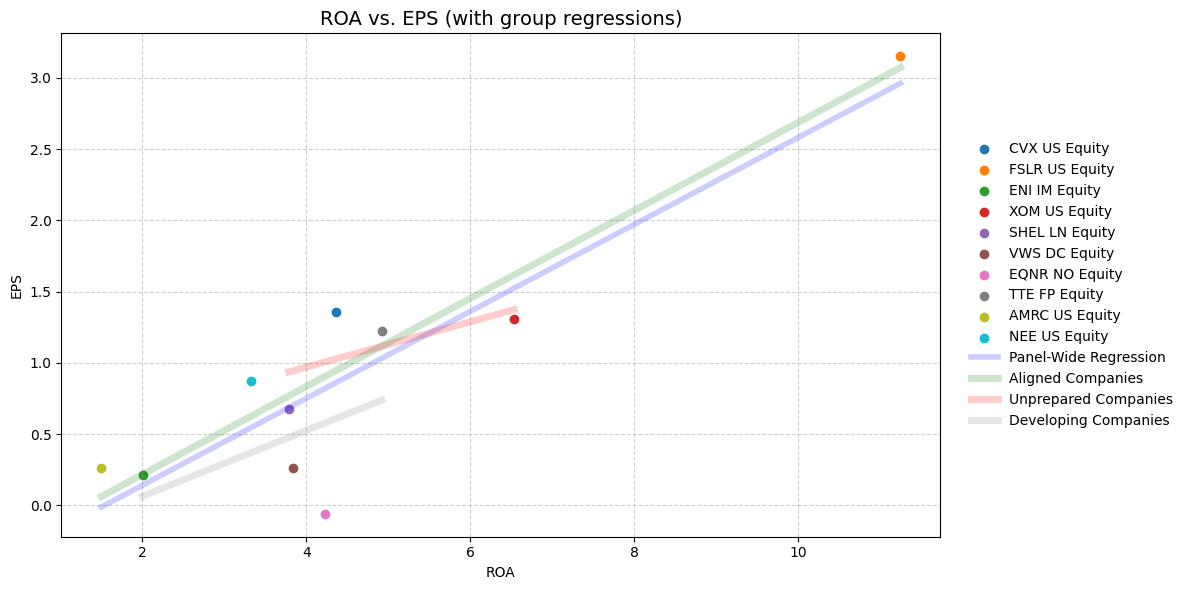

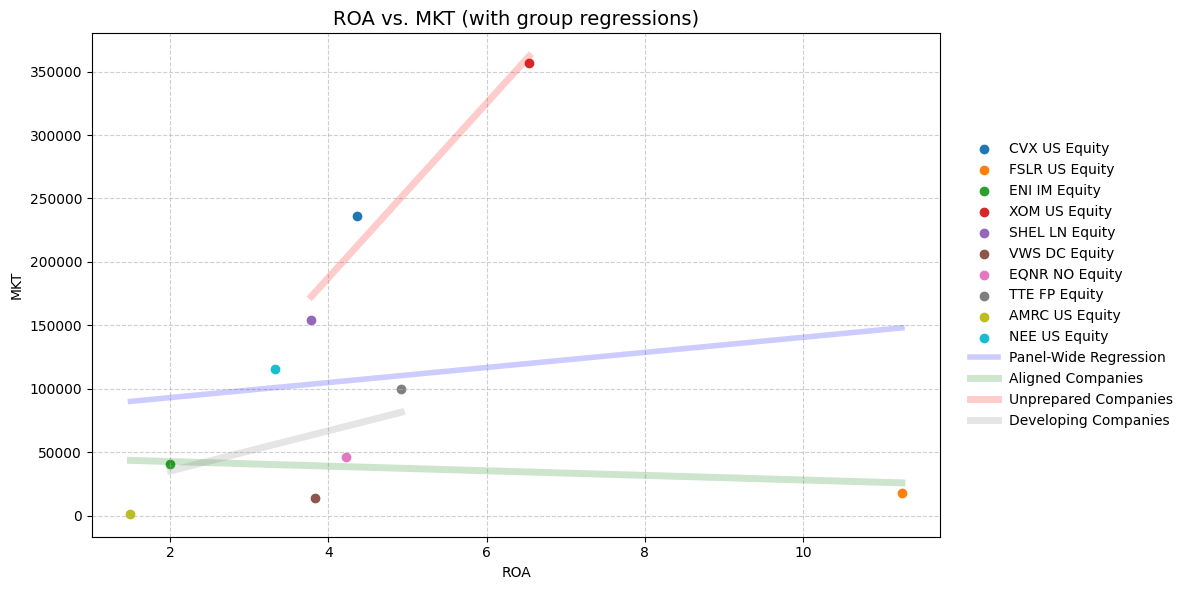

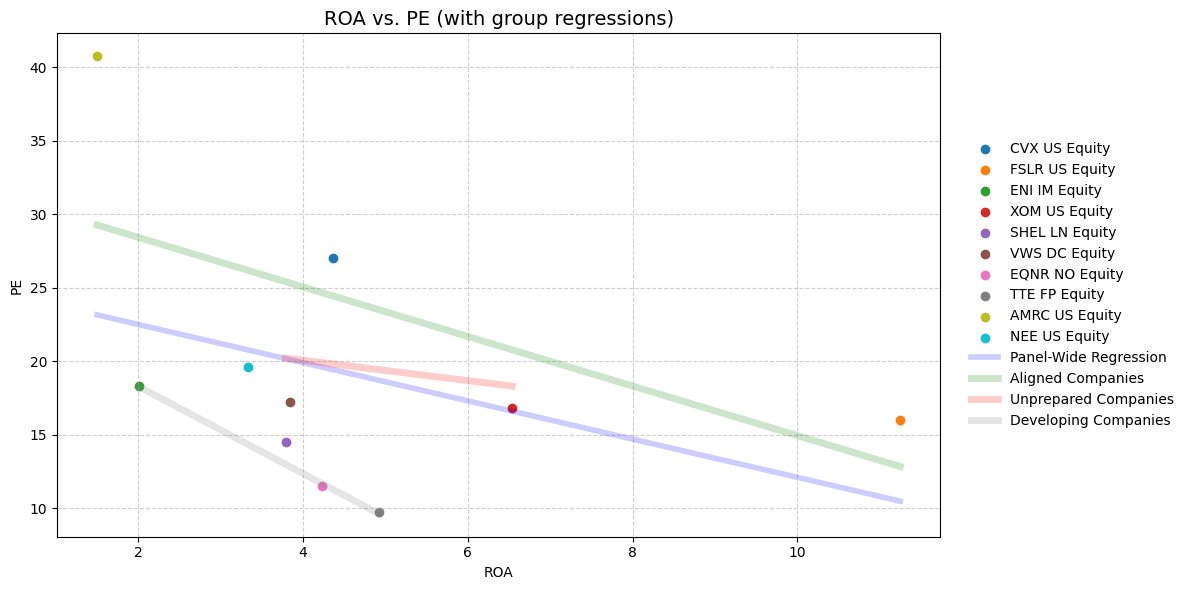

In [33]:
#| label : scatter_fundamentals_ROA

Quick_scatter(ROA, EPS2, "ROA", "EPS", panelreg = True)
Quick_scatter(ROA, MKT2, "ROA", "MKT", panelreg = True)
Quick_scatter(ROA, PE2,  "ROA", "PE", panelreg =True)


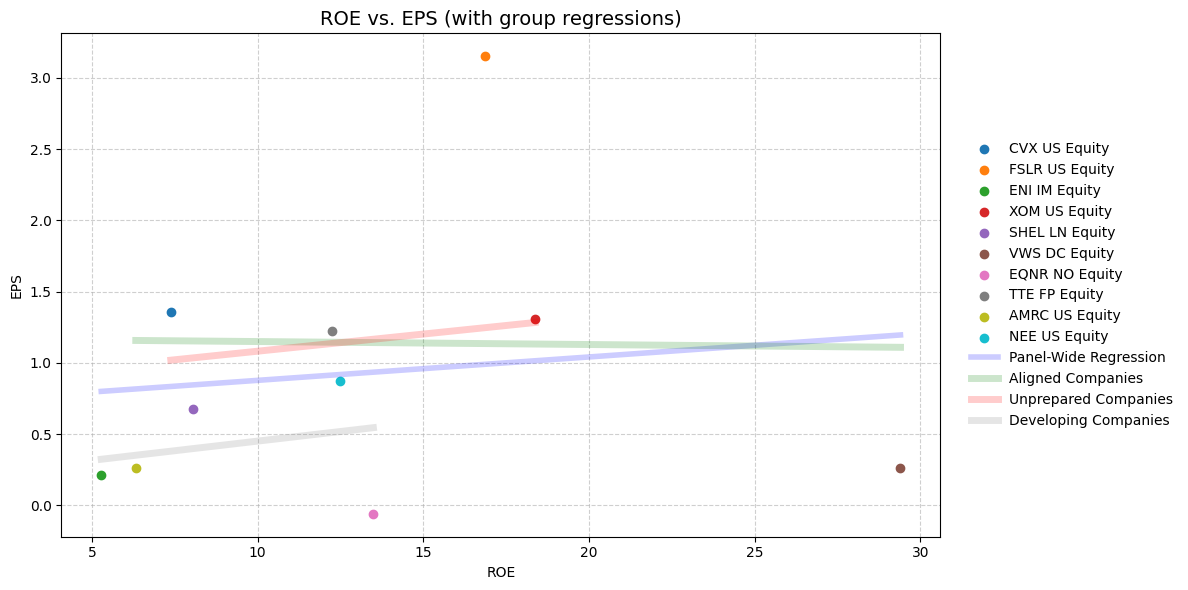

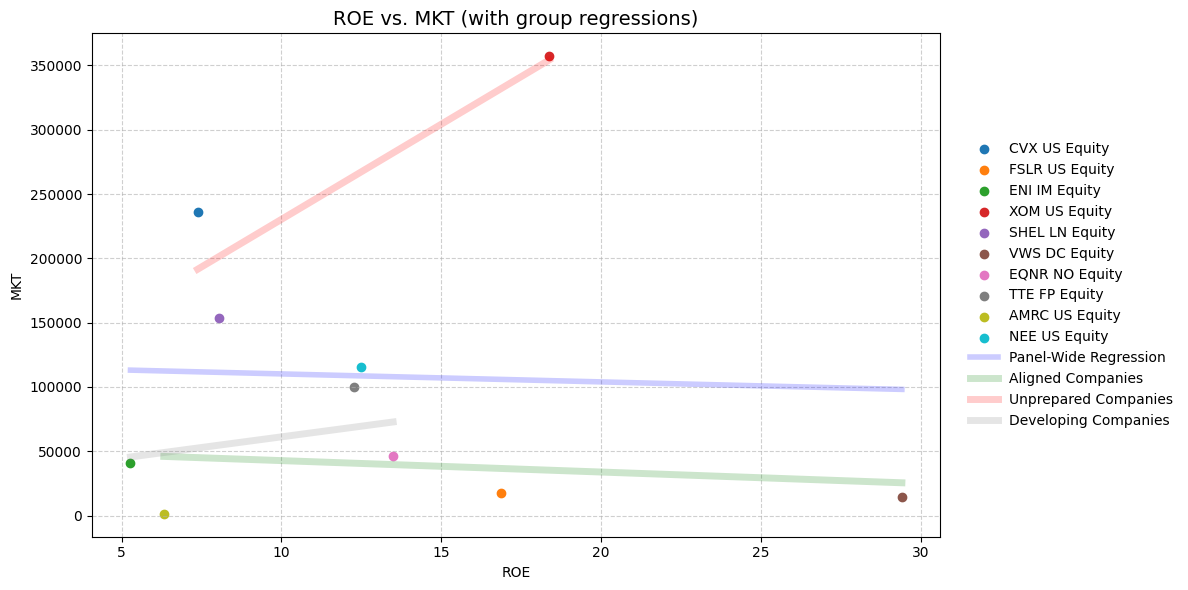

In [34]:
#| label : scatter_fundamentals_ROE
Quick_scatter(ROE, EPS2, "ROE", "EPS", panelreg = True)
Quick_scatter(ROE, MKT2, "ROE", "MKT", panelreg = True)


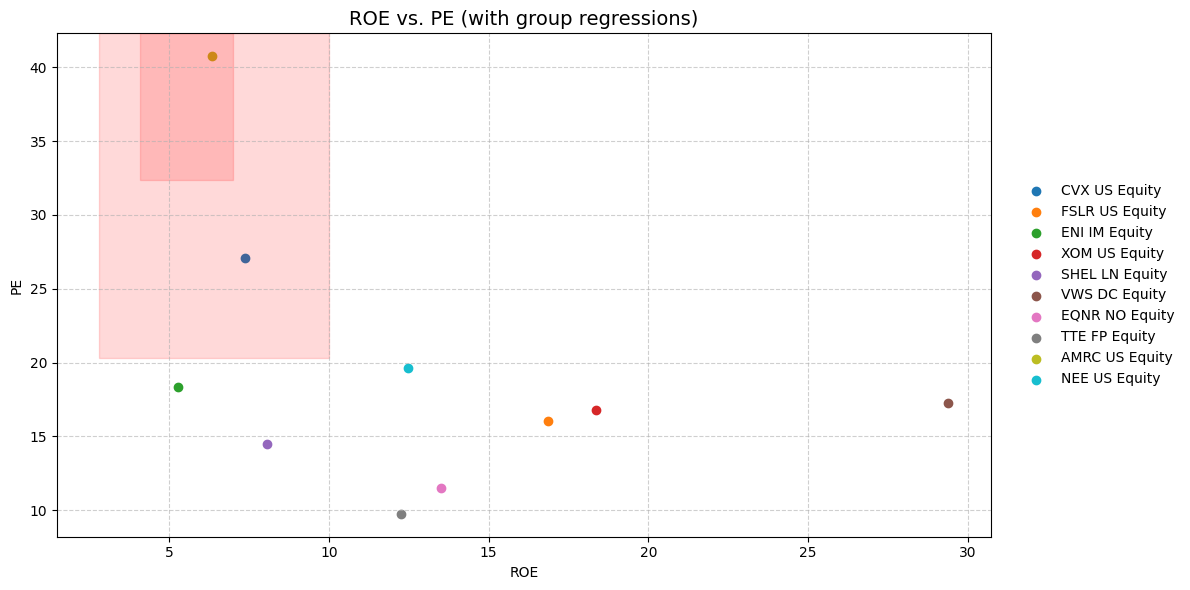

In [35]:
Quick_scatter(ROE, PE2,  "ROE", "PE", panelreg = False, groupreg = False)
# Horizontal and vertical thresholds
x_thresh = 7    # ROE
y_thresh = 30   # PE

# Shade region: x < 10 (vertical span), y > 30 (horizontal span)
plt.axvspan(xmin=plt.xlim()[0], xmax=x_thresh, ymin=y_thresh / plt.ylim()[1], ymax=1,
color='red', alpha=0.15, label='Low ROE & High PE Region')

x_thresh = 10   # ROE
y_thresh = 15   # PE
# Shade region: x < 10 (vertical span), y > 30 (horizontal span)
plt.axvspan(xmin=plt.xlim()[0], xmax=x_thresh, ymin=y_thresh / plt.ylim()[1], ymax=1,
color='red', alpha=0.15, label='Low ROE & High PE Region')


### Growth

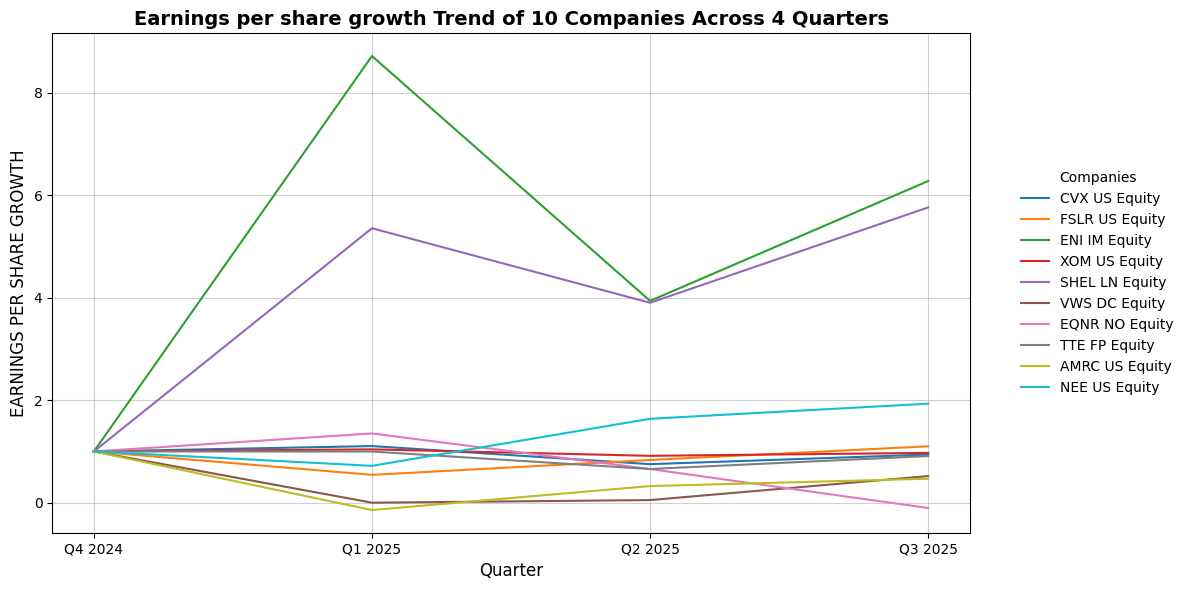

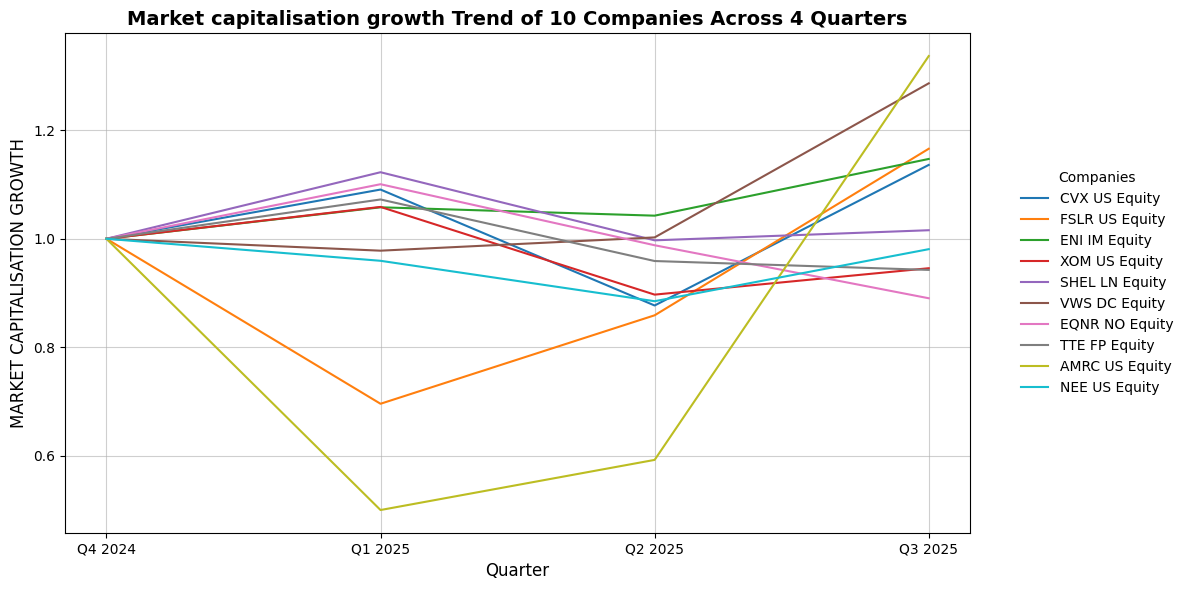

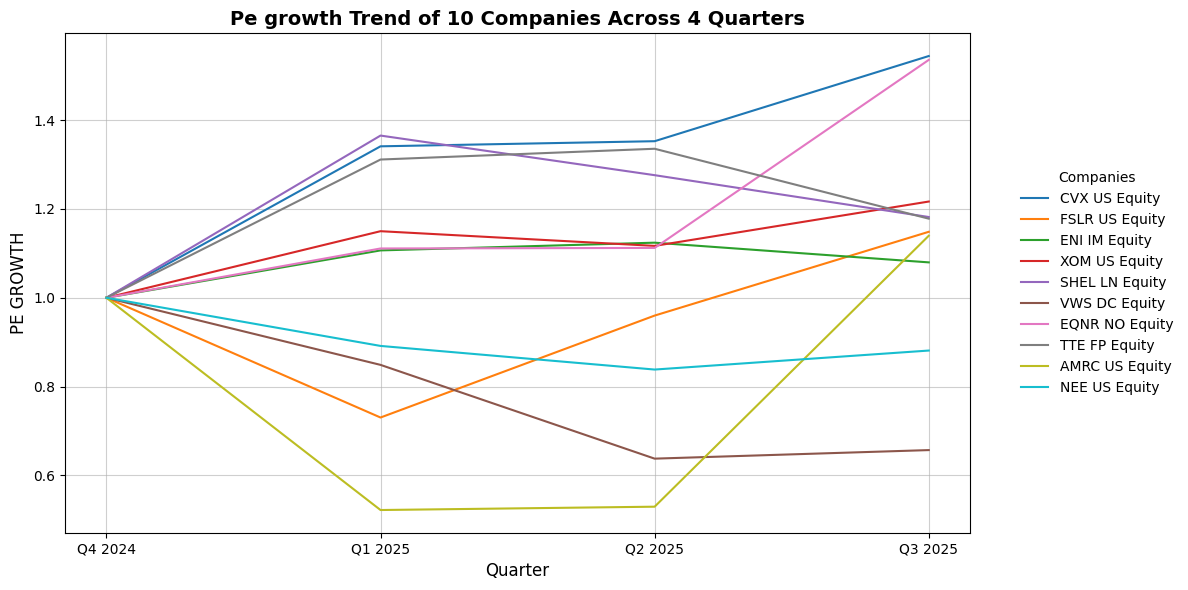

In [36]:
#| label: fundamentals_growth
basic_plot(EPS.iloc[:, 1:].div(EPS.iloc[0, 1:], axis=1), "Earnings per Share Growth")
basic_plot(MKT.iloc[:, 1:].div(MKT.iloc[0, 1:], axis=1), "Market Capitalisation Growth")
basic_plot(PE.iloc[:, 1:].div(PE.iloc[0, 1:], axis=1), "PE Growth")


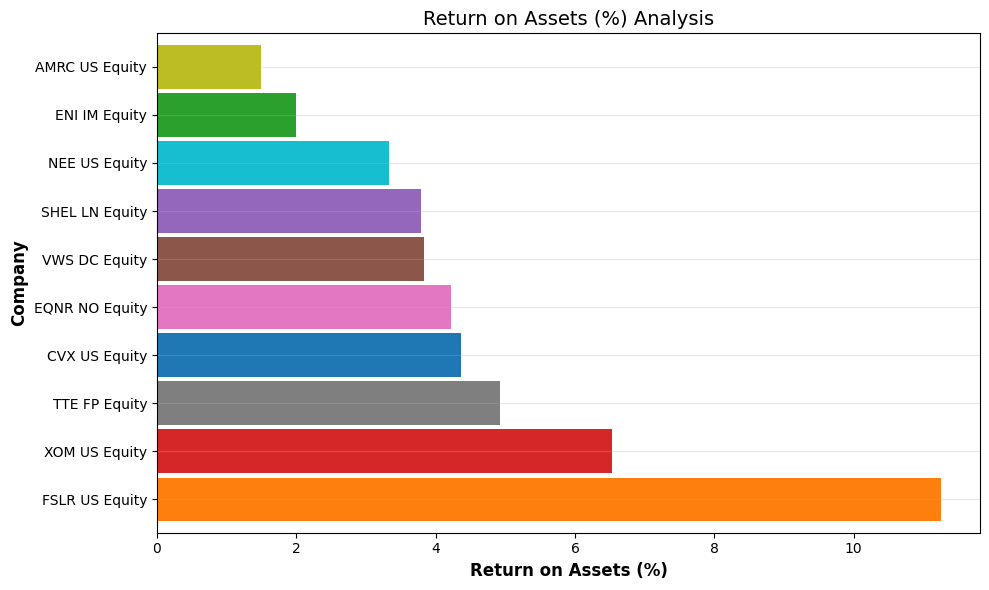

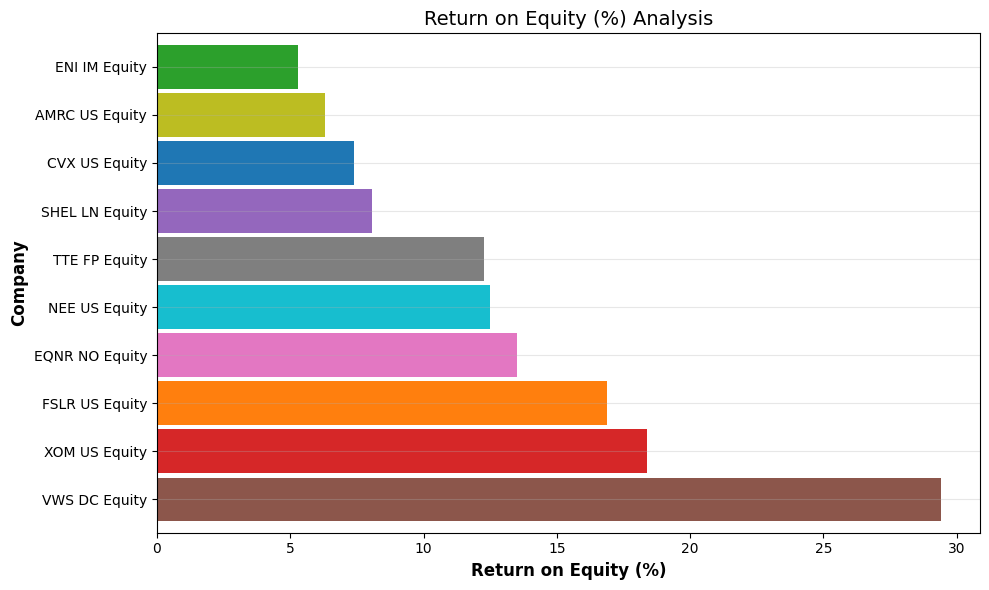

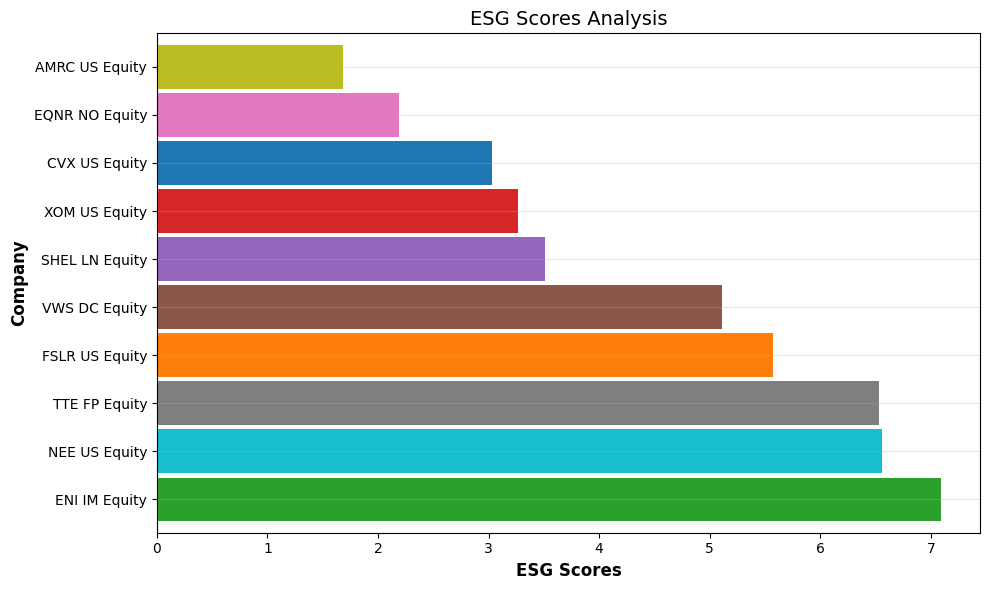

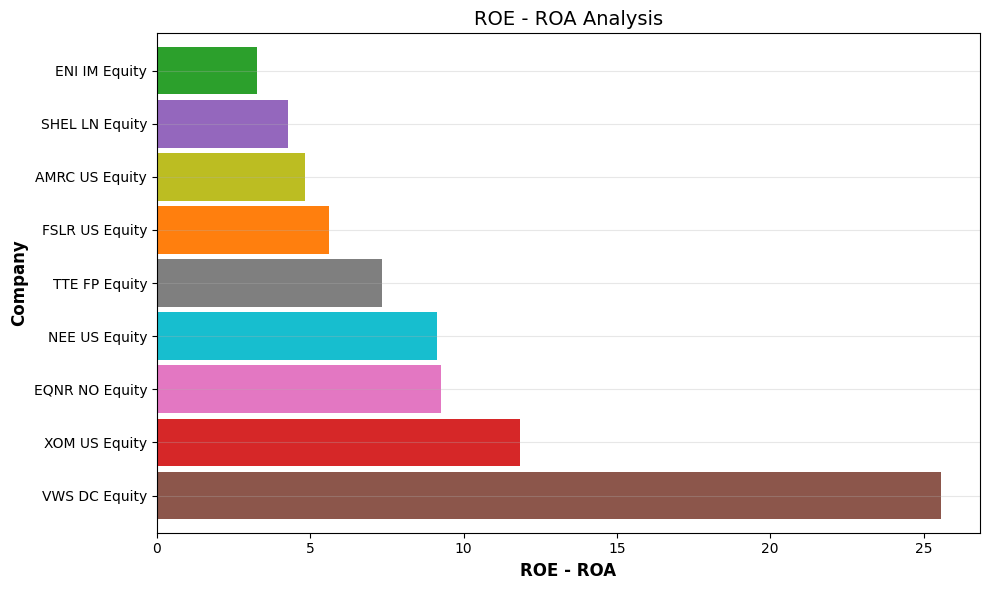

In [37]:
#| label: simple_bar_chart
def simple_bar_chart(data, title, ylabel = "Company"):

    colors = {
    'CVX US Equity': '#1f77b4',
    'FSLR US Equity': '#ff7f0e',
    'ENI IM Equity': '#2ca02c',
    'XOM US Equity': '#d62728',
    'SHEL LN Equity': '#9467bd',
    'VWS DC Equity': '#8c564b',
    'EQNR NO Equity': '#e377c2',
    'TTE FP Equity': '#7f7f7f',
    'AMRC US Equity': '#bcbd22',
    'NEE US Equity': '#17becf'
    }

    plot_data = data.iloc[0, 1:].sort_values(ascending=False)
    bar_colors = [colors[ticker] for ticker in plot_data.index]

    plt.figure(figsize=(10, 6))
    plot_data.plot(kind='barh', color=bar_colors, width=0.9)
    plt.xlabel(title, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(f"{title} Analysis", fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

simple_bar_chart(ROA, "Return on Assets (%)")
simple_bar_chart(ROE, "Return on Equity (%)")
simple_bar_chart(ESG, "ESG Scores")
DIFF = (ROE.transpose().iloc[-10:] - ROA.transpose().iloc[-10:])
simple_bar_chart(DIFF.transpose(), "ROE - ROA")


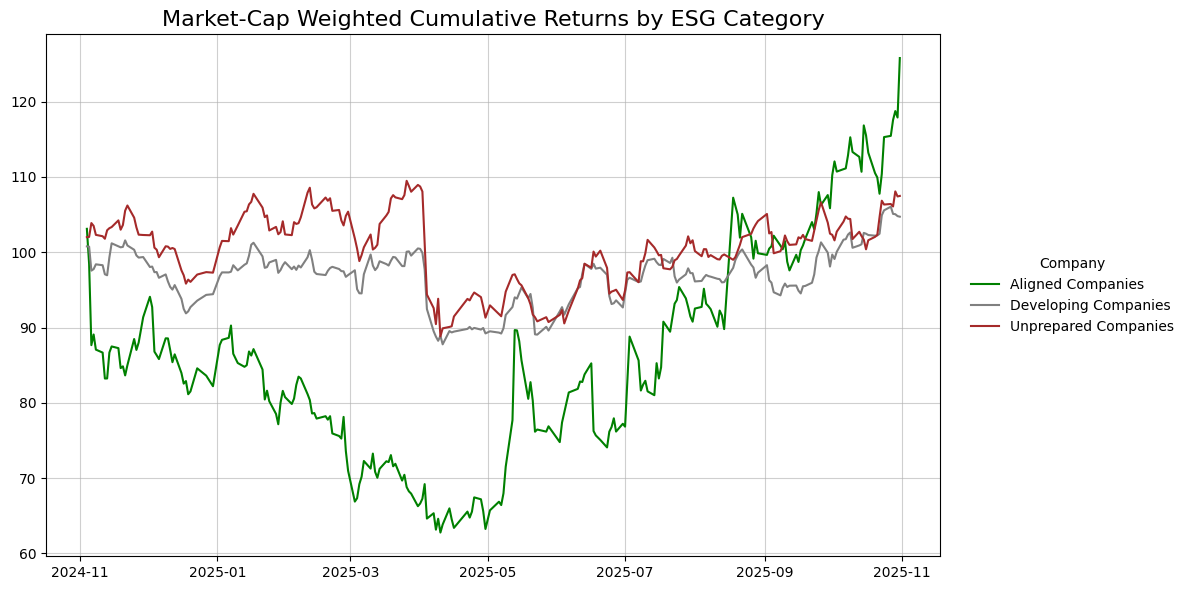

Text(0.5, 1.0, 'Cumulative Returns by ESG Category Equally weighted')

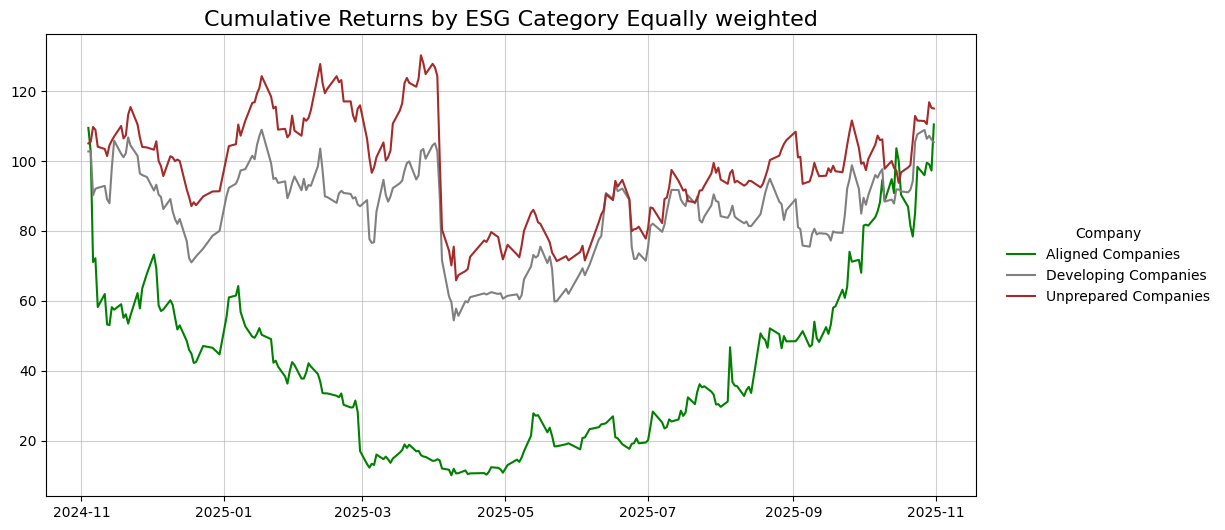

In [38]:
#| label: cumulative_returns_ESG_groups
MKTL = MKT.iloc[3:,:]
MKTL[['CVX US Equity', 'XOM US Equity', 'SHEL LN Equity']]
# Compute group weights
GREEN_weights = MKTL[['VWS DC Equity', 'FSLR US Equity', 'AMRC US Equity']].div(
    MKTL[['VWS DC Equity', 'FSLR US Equity', 'AMRC US Equity']].sum(axis=1), axis=0
).iloc[0] 

TRANSITIONAL_weights = MKTL[['ENI IM Equity', 'TTE FP Equity', 'EQNR NO Equity', 'NEE US Equity']].div(
    MKTL[['ENI IM Equity', 'TTE FP Equity', 'EQNR NO Equity', 'NEE US Equity']].sum(axis=1), axis=0
).iloc[0] 

BROWN_weights = MKTL[['CVX US Equity', 'XOM US Equity', 'SHEL LN Equity']].div(
    MKTL[['CVX US Equity', 'XOM US Equity', 'SHEL LN Equity']].sum(axis=1), axis=0
).iloc[0] 


GREEN_ret = (returns[['VWS DC Equity', 'FSLR US Equity', 'AMRC US Equity']] * GREEN_weights).sum(axis=1)
TRANSITIONAL_ret = (returns[['ENI IM Equity', 'TTE FP Equity', 'EQNR NO Equity', 'NEE US Equity']] * TRANSITIONAL_weights).sum(axis=1)
BROWN_ret = (returns[['CVX US Equity', 'XOM US Equity', 'SHEL LN Equity']] * BROWN_weights).sum(axis=1)


cum_GREEN_ret = 100 * (1 + GREEN_ret).cumprod()
cum_TRANSITIONAL_ret = 100 * (1 + TRANSITIONAL_ret).cumprod()
cum_BROWN_ret = 100 * (1 + BROWN_ret).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_GREEN_ret, label='Aligned Companies', color='green')
plt.plot(cum_TRANSITIONAL_ret, label='Developing Companies', color='gray')
plt.plot(cum_BROWN_ret, label='Unprepared Companies', color='brown')

plt.grid(axis='both', linestyle='-', alpha=0.6)
plt.legend(title="Company", loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=False)
plt.title("Market-Cap Weighted Cumulative Returns by ESG Category", fontsize=16)
plt.tight_layout()
plt.show()

GREEN = returns[['VWS DC Equity', 'FSLR US Equity', "AMRC US Equity"]].sum(axis=1) 
TRANSITIONAL = returns[['ENI IM Equity', 'TTE FP Equity', "EQNR NO Equity", "NEE US Equity"]].sum(axis=1) 
BROWN = returns[['CVX US Equity', 'XOM US Equity', "SHEL LN Equity"]].sum(axis=1) 

cum_GREEN_ret = 100 * (1 + GREEN).cumprod()
cum_TRANSITIONAL_ret = 100 * (1 + TRANSITIONAL).cumprod()
cum_BROWN_ret = 100 * (1 + BROWN).cumprod()


plt.figure(figsize=(12, 6)) 
plt.plot(cum_GREEN_ret, label='Aligned Companies', color='green') 
plt.plot(cum_TRANSITIONAL_ret, label='Developing Companies', color='gray') 
plt.plot(cum_BROWN_ret, label='Unprepared Companies', color='brown') 
plt.grid(axis='both', linestyle='-', alpha=0.6) 
plt.legend(title="Company", loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=False) 
plt.title("Cumulative Returns by ESG Category Equally weighted", fontsize=16)


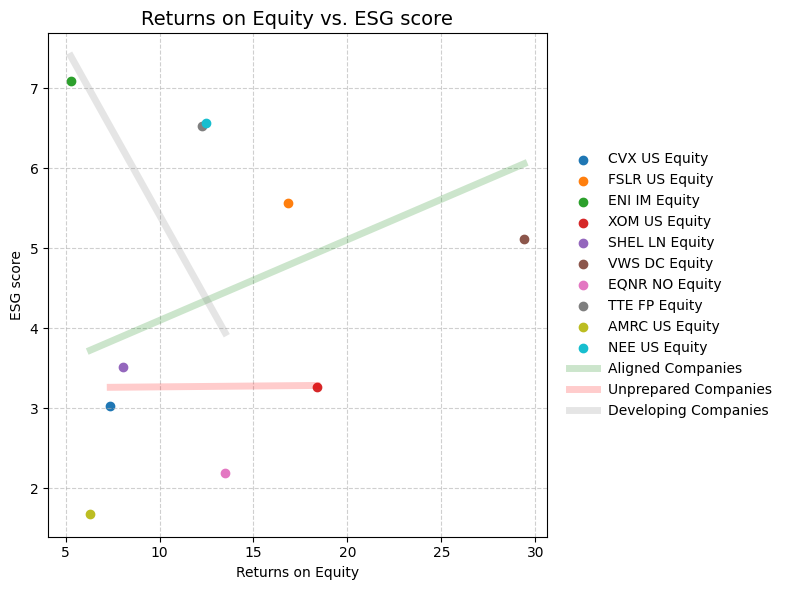

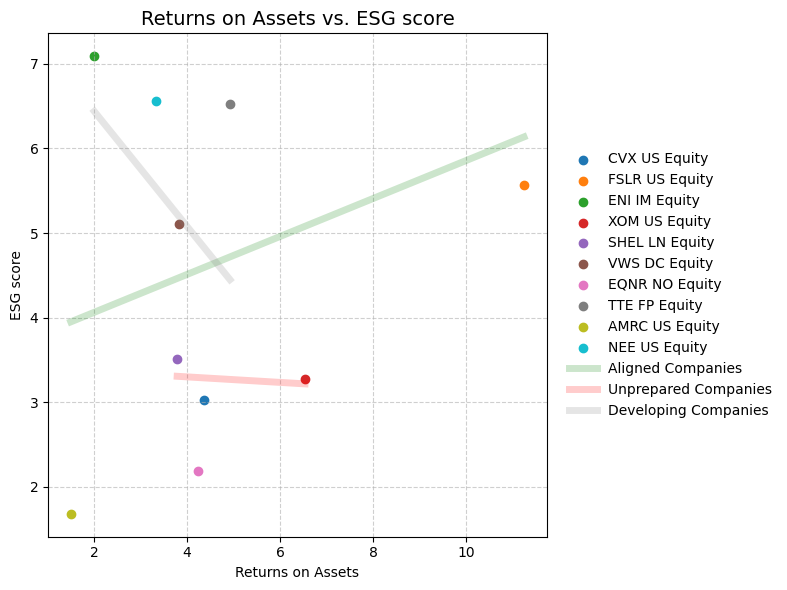

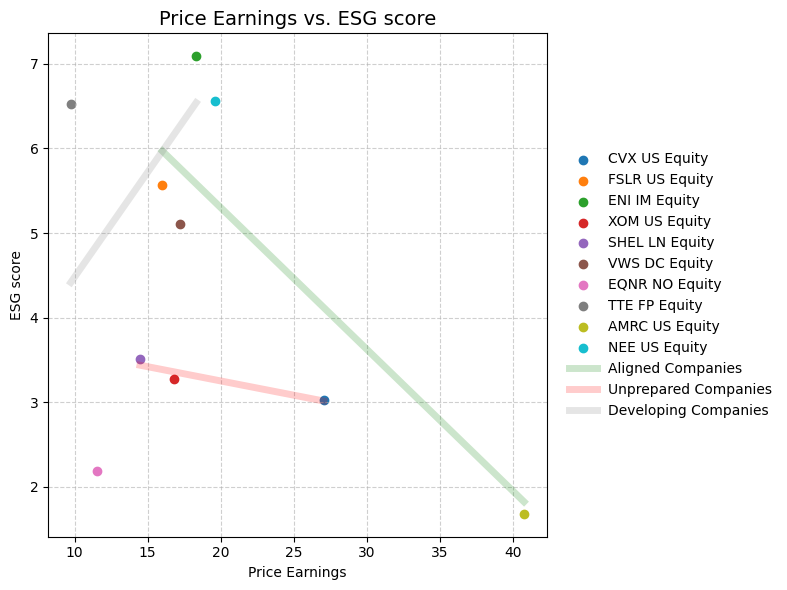

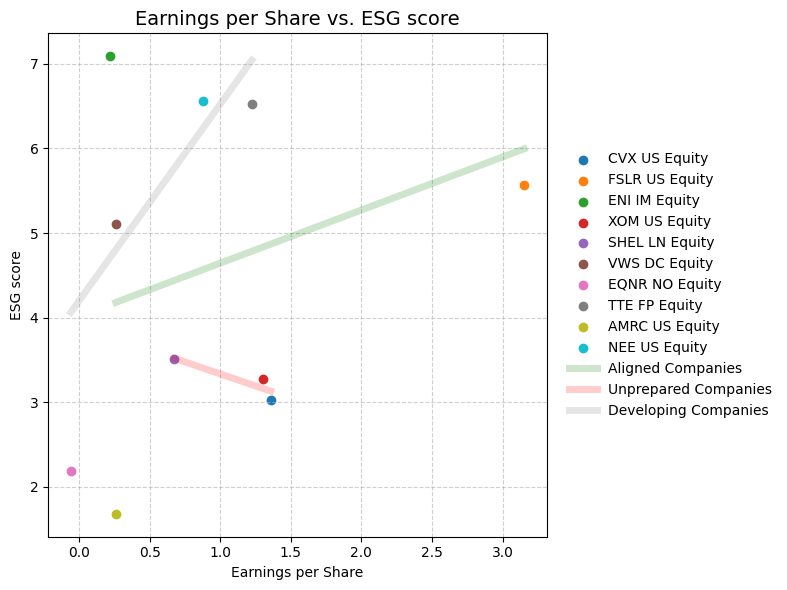

In [39]:
def Quick_scatter(Data1, Data2, label1, label2, ylog=False, xlog=False, panelreg = False, groupreg = True):
        # Collect all data for panel regression
    all_data1 = []
    all_data2 = []
    plt.figure(figsize=(8, 6))
    
    if groupreg:
    # ---- classify companies ----
        green_status = {
            "CVX US Equity": "no",
            "FSLR US Equity": "yes",
            "ENI IM Equity": "some",
            "XOM US Equity": "no",
            "SHEL LN Equity": "no",
            "VWS DC Equity": "yes",
            "EQNR NO Equity": "some",
            "TTE FP Equity": "some",
            "AMRC US Equity": "yes",
            "NEE US Equity": "yes"
        }


        # If you want: define green = yes only
        green_companies = [c for c,s in green_status.items() if s == "yes"]
        non_green_companies = [c for c,s in green_status.items() if s == "no"]
        some_companies = [c for c,s in green_status.items() if s == "some"]  # optional


        # Also prepare lists for green/non-green group regressions
        green_x = []
        green_y = []
        nongreen_x = []
        nongreen_y = []
        some_x = []
        some_y = []

    # --- Plot scatter + company-level regressions ---
    for company in company_columns:
        Data1_series = Data1[company]
        Data2_series = Data2[company]

        all_data1.append(Data1_series)
        all_data2.append(Data2_series)
        if groupreg:
            # Add to correct group
            if company in green_companies:
                green_x.append(Data1_series)
                green_y.append(Data2_series)
            elif company in non_green_companies:
                nongreen_x.append(Data1_series)
                nongreen_y.append(Data2_series)
            elif company in some_companies:
                some_x.append(Data1_series)
                some_y.append(Data2_series)

        # Company scatter
        plt.scatter(Data1_series, Data2_series, label=company)

        # Company individual regression
        # sns.regplot(
        #     x=Data1_series.values,
        #     y=Data2_series.values,
        #     scatter=False,
        #     ci=None,
        #     line_kws={'alpha': 0.6, 'linewidth': 1}
        # )

    # --- Convert group lists ---
    if groupreg:
        gx = pd.concat(green_x).values if green_x else None
        gy = pd.concat(green_y).values if green_y else None
        nx = pd.concat(nongreen_x).values if nongreen_x else None
        ny = pd.concat(nongreen_y).values if nongreen_y else None
        sx = pd.concat(some_x).values if some_x else None
        sy = pd.concat(some_y).values if some_y else None

    if panelreg:
        # --- Panel-wide regression ---
        all_x = pd.concat(all_data1).values
        all_y = pd.concat(all_data2).values
        sns.regplot(
            x=all_x, y=all_y,
            scatter=False, ci=None,
            label='Panel-Wide Regression',
            line_kws={'color': 'blue', 'linewidth': 4, 'alpha': 0.2}
        )

    if groupreg:
        # --- Group Regressions ---
        if gx is not None:
            sns.regplot(
                x=gx, y=gy,
                scatter=False, ci=None,
                label='Aligned Companies',
                line_kws={'color': 'green', 'linewidth': 5, 'alpha': 0.2}
            )

        if nx is not None:
            sns.regplot(
                x=nx, y=ny,
                scatter=False, ci=None,
                label='Unprepared Companies',
                line_kws={'color': 'red', 'linewidth': 5, 'alpha': 0.2}
            )

        if sx is not None:
            sns.regplot(
                x=sx, y=sy,
                scatter=False, ci=None,
                label='Developing Companies',
                line_kws={'color': 'gray', 'linewidth': 5, 'alpha': 0.2}
        )

    # --- Formatting ---
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

    plt.title(f'{label1} vs. {label2}', fontsize=14)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.grid(True, ls="--", alpha=0.6)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.tight_layout()


Quick_scatter(ROE, ESG, "Returns on Equity", "ESG score")


Quick_scatter(ROA, ESG, "Returns on Assets", "ESG score")

Quick_scatter(PE2, ESG, "Price Earnings", "ESG score")
Quick_scatter(EPS2, ESG, "Earnings per Share", "ESG score")



In [ ]:
# | include: false
# | label: final_beep
# | error: false
try:
    from beepy.beep import beep
    beep(15)
    print("Beep played successfully!")
except Exception as e:
    print(f"Beep failed: {e}")


Beep played successfully!
